In [335]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aux.ts_functions as ts
import seaborn as sns; sns.set()
import numpy as np
import warnings
import os
from scipy.stats import pearsonr
from IPython.display import Image
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import glob
from scipy.special import comb
from functools import reduce
import re

data_dir = "./../data/"
image_dir = "./final_images/"
imputed_data_dir = "./imputed_data/"

dsp_axis = "DSP toxicity"
lag_axis = "Temporal lag"
pearson_axis = "Pearson Correlation"
dpcca_axis = "DPCCA coefficient"
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

# Functions

In [423]:
tradutor = {"Mexilhão": "Mussel", "Berbigão":"Cockle", "Amêijoa-branca": "Surf clam", "Conquilha":"Conquina clam"}

def get_ts(df, area, specie, toxin, resample_code, plot=True, show_df=False):
    if not isinstance(toxin, list):
        toxin = [toxin]
    ts = df[ (df["Production_Area"]==area) & (biotoxins_ts["Species"]==specie)]
    ts = ts.resample(resample_code).mean()
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ts.plot(ax=ax, marker='o', markersize=2)
    if show_df: 
        display(ts[toxin].head())
    return ts[toxin]

def get_ts_imputed(area, specie, toxin, suf, data_dir='/imputed_data', only_target=False):
    if suf == "areacorr":
        file_name = suf + '__' + area + '__' + toxin + '_' + specie
    elif suf == "speciecorr":
        file_name = suf + '__' + area + '_' + specie + '__' + toxin
    elif suf == "phytocorr":
        file_name = suf + '__' + area + '__' + toxin
    else:
        raise ValueError(f"Suffix {suf} is not valid.")
                    
    file = glob.glob(f'.{data_dir}/{file_name}*.csv')
    if len(file)>1:
        raise ValueError(f"Multiple files found when searching for '{file_name}'")
    elif len(file) == 0:
        raise FileNotFoundError(f"File '{file_name}' found")
    else:
        ts = pd.read_csv(file[0], index_col='Date', parse_dates=True)
        if only_target:
            if specie != None:
                return ts[[target + '_' + specie]]
            else:
                return ts[[target.replace('toxins','phyto')]]
        else:
            return ts

        
def subplot_dim(total, n_cols):
    rows = total//n_cols
    if total%n_cols!=0:
        rows+=1
    return rows, n_cols


def plot_season_per(ts, by, ax, toxin='dsp_toxins', hline=160):
    ts = ts.copy()
    ts['year'] = [d.year for d in ts.index]
    years = ts['year'].unique()

    if by.lower() == "w":
        code = '%W'
    elif by.lower() == "m":
        code = '%b'
        
    ts['per'] = [d.strftime(code) for d in ts.index]

    for i, y in enumerate(years):
        per_year = ts.loc[ts['year']==y]
        ax.plot('per', toxin, data=per_year, label=y, marker='o', markersize=3)
    
    ax.set_title(f"Per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    ax.legend()
    return ax

def compare_species_seasonality(df, area, species: list, toxin, by, ax, hline, graphic):
    final_ts = pd.DataFrame(columns=[toxin, 'per', 'year', 'type'])
    years = []
    for s in species:
        ts = get_ts(df, area, s, toxin, by, plot=False)
        ts.insert(1,"specie", s)
        ts['year'] = [d.year for d in ts.index]
        years += list(ts['year'].unique())

        if by.lower() == "w":
            code = '%W'
        elif by.lower() == "m":
            code = '%b'
        ts['per'] = [d.strftime(code) for d in ts.index]
        final_ts = final_ts.append(ts, ignore_index=True)
        
    years = sorted(list(set(years)))
    
    if graphic == "boxplot":
        sns.boxplot(x="per", y=toxin, hue="specie", data=final_ts, ax=ax)
    elif graphic == "lineplot":
        sns.lineplot(x='per', y=toxin, hue="specie", data=final_ts, ax=ax, marker='o', markersize=3)
    else:
        raise ValueError('graphic must be boxplot or lineplot')
        
    ax.set_title(f"{toxin} per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

def compare_species_trend(df, area, species: list, toxin, ax, hline, graphic):
    final_ts = pd.DataFrame(columns=[toxin, 'per', 'year', 'type'])
    years = []
    for s in species:
        ts = get_ts(df, area, s, toxin, "M", plot=False)
        ts.insert(1,"specie", s)
        ts['year'] = [d.year for d in ts.index]
        years += list(ts['year'].unique())

        ts['month'] = [d.strftime('%b') for d in ts.index]
        final_ts = final_ts.append(ts, ignore_index=True)
        
    years = sorted(list(set(years)))
    
    if graphic == "boxplot":
        sns.boxplot(x="year", y=toxin, hue="specie", data=final_ts, ax=ax)
    elif graphic == "lineplot":
        sns.lineplot(x='year', y=toxin, hue="specie", data=final_ts, ax=ax, marker='o', markersize=3)
    else:
        raise ValueError('graphic must be boxplot or lineplot')
        
    ax.set_title(f"{toxin}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

def plot_corrs_together(all_areas, min_corr, lags, area_groups, specie, target, axes, suf="areacorr", type_corr="Pearson",
                      subplots_per_line=4, use_imputed=True, remove_default=False, min_points_default=20):
    selected_areas = set()
    all_corrs = []
    k_dict = {}
    for i in range(len(all_areas)):
        for j in range(i):
            area1, area2 = all_areas[i], all_areas[j]
            key = " & ".join(sorted([area1, area2]))
            
            check_groups = sum([ (area1 in g and area2 in g) for g in area_groups ])
            if check_groups:
                print("skip check groups")
                continue
            
            try:
                if use_imputed:
                    ts1 = get_ts_imputed(area1, specie, target, suf, only_target=True)
                    ts2 = get_ts_imputed(area2, specie, target, suf, only_target=True)
                else:
                    ts1 = get_ts(biotoxins_ts, area1, specie, target, "W", plot=False).interpolate(method="linear")
                    ts2 = get_ts(biotoxins_ts, area2, specie, target, "W", plot=False).interpolate(method="linear")
            except FileNotFoundError:
                continue
            
            df = pd.merge(ts1, ts2, left_index=True, right_index=True)

            col1, col2 = df.columns
            df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'areas': key})
            
          
                
            plot = False
            for lag in lags:
                temp = df.copy()
                shift_ts = temp[col2].shift(lag)
                if type_corr.lower() == 'pearson':
                    if remove_default:
                        default = temp[col1].mode().values[0]
                        temp = temp[~((abs(temp[col1]-default)<default*0.05) & (abs(shift_ts-default)<default*0.05))]                        
                    corr = temp[col1].corr(shift_ts, method='pearson', min_periods=min_points_default)
                else:
                    raise ValueError("Invalid type_corr")
                df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
                if abs(corr) > min_corr:
                    plot = True
                    
            if plot:
                all_corrs.append(df_corrs)
        
    if len(all_corrs)==0:
        raise ValueError("Threshold too high, no correlations found")
    all_corrs = pd.concat(all_corrs).reset_index(drop=True)
    selected_areas = all_corrs["areas"].unique()
    
    sns.lineplot(data=all_corrs, x="lags", y="corrs", hue="areas", marker='o', markersize=4, ax=axes)

    axes.tick_params(axis='both', labelsize="x-small")
    axes.set(xlabel=None, ylabel=None)
    axes.axvline(0, linestyle="--", color="r", linewidth=0.5)
    axes.axhline(0, linestyle="-", color="black", linewidth=0.5)

    return axes

def plot_corrs_single(all_areas, min_corr, lags, area_groups, specie, target, suf="areacorr", type_corr="Pearson",
                      subplots_per_line=4, use_imputed=True, k_range=range(2,21,2), remove_default=False,
                     min_points_default=20, annotate=None):
    selected_areas = set()
    all_corrs = []
    k_dict = {}
    for i in range(len(all_areas)):
        for j in range(i):
            area1, area2 = all_areas[i], all_areas[j]
            key = " & ".join(sorted([area1, area2]))
            
            check_groups = sum([ (area1 in g and area2 in g) for g in area_groups ])
            if check_groups:
                continue
            
            try:
                if use_imputed:
                    ts1 = get_ts_imputed(area1, specie, target, suf, only_target=True)
                    ts2 = get_ts_imputed(area2, specie, target, suf, only_target=True)
                else:
                    ts1 = get_ts(biotoxins_ts, area1, specie, target, "W", plot=False).interpolate(method="linear")
                    ts2 = get_ts(biotoxins_ts, area2, specie, target, "W", plot=False).interpolate(method="linear")
            except FileNotFoundError:
                continue
            
            df = pd.merge(ts1, ts2, left_index=True, right_index=True)
            col1, col2 = df.columns
            df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'pvalue': np.nan, 'annotate': False,
                                     'areas': key})
            
          
                
            plot = False
            for lag in lags:
                temp = df.copy()
                shift_ts = temp[col2].shift(lag)
                if type_corr.lower() == 'pearson':
                    if remove_default:
                        default = temp[col1].mode().values[0]
                        temp = temp[~((abs(temp[col1]-default)<default*0.05) & (abs(shift_ts-default)<default*0.05))]                        
                    #corr = temp[col1].corr(shift_ts, method='pearson', min_periods=min_points_default)
                    to_corr = pd.DataFrame({ 'a': temp[col1], 'b': shift_ts }).dropna()
                    corr, pvalue = pearsonr(to_corr['a'].values, to_corr['b'].values)
                else:
                    raise ValueError("Invalid type_corr")
                df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
                df_corrs.loc[df_corrs['lags'] == lag, 'pvalue'] = pvalue

                if abs(corr) > min_corr:
                    plot = True

            if plot:
                if annotate != None:
                    index_top = df_corrs["corrs"].nlargest(n=annotate).index
                    df_corrs.at[index_top, 'annotate'] = True
                all_corrs.append(df_corrs)

                
        
    if len(all_corrs)==0:
        raise ValueError("Threshold too high, no correlations found")
    all_corrs = pd.concat(all_corrs)
    selected_areas = all_corrs["areas"].unique()
    
    rows, columns = subplot_dim(len(selected_areas), subplots_per_line)
    fig, axes = plt.subplots(rows, columns, 
                             figsize=(8, 3*rows), constrained_layout=True, 
                             sharey=True, squeeze=False)

    axes = axes.ravel()
    for i, areas in enumerate(selected_areas):
        temp_df = all_corrs[all_corrs["areas"] == areas]
        sns.lineplot(data=temp_df, x="lags", y="corrs", marker='o', markersize=4, ax=axes[i])
        if type_corr.lower() in ['dpcca', 'dcca']:
            anchored_text = AnchoredText(f"k={k_dict[areas]}", loc='lower left', prop=dict(size=8))
            axes[i].add_artist(anchored_text)
        axes[i].set_title(f'{areas}', size="small")
        axes[i].tick_params(axis='both', labelsize="x-small")
        axes[i].set(xlabel=None, ylabel=None)
        #axes[i].set_ylim(-0.2,1)
        axes[i].axvline(0, linestyle="--", color="r", linewidth=0.5)
        axes[i].axhline(0, linestyle="-", color="black", linewidth=0.5)
        
        if annotate!=None:
            shifts = [-0.3]*(annotate//2) + [0.3]*(annotate - (annotate//2))
            aligns = ["right"]*(annotate//2) + ["left"]*(annotate - (annotate//2))
            for line in range(0,temp_df.shape[0]):
                if temp_df["annotate"][line]:
                    axes[i].text(temp_df["lags"][line]+shifts.pop(0), temp_df["corrs"][line], 
                            round(temp_df["pvalue"][line],5), horizontalalignment=aligns.pop(0), size='xx-small', 
                            color='black')


    return axes

def plot_dpcca_single(all_areas, min_corr, lags, area_groups, specie, target, suf="areacorr", 
                      type_corr="dpcca", subplots_per_line=3, use_imputed=True, k_range=[12]):
    selected_areas = set()
    all_corrs = []
    k_dict = {}
    for i in range(len(all_areas)):
        for j in range(i):
            area1, area2 = all_areas[i], all_areas[j]
            key = " & ".join(sorted([area1, area2]))
            
            ###########
            if key == "L7c1 & OLH2": continue
            ##########
            check_groups = sum([ (area1 in g and area2 in g) for g in area_groups ])
            if check_groups:
                continue
            
            try:
                if use_imputed:
                    ts1 = get_ts_imputed(area1, specie, target, suf, only_target=True)
                    ts2 = get_ts_imputed(area2, specie, target, suf, only_target=True)
                else:
                    ts1 = get_ts(biotoxins_ts, area1, specie, target, "W", plot=False).interpolate(method="linear")
                    ts2 = get_ts(biotoxins_ts, area2, specie, target, "W", plot=False).interpolate(method="linear")
            except FileNotFoundError:
                continue
            
            df = pd.merge(ts1, ts2, left_index=True, right_index=True)
            col1, col2 = df.columns
            
            
            df_corrs = pd.DataFrame(columns=["lags", "corrs","areas",'n'])
            for n in k_range:
                df_corrs = df_corrs.append(pd.DataFrame({'lags':lags, 'corrs':np.nan, 'areas':key, 'n':str(n)}),
                                          ignore_index=True)
            #display(df_corrs)
            
            plot = False
            for n in k_range:
                for lag in lags:
                    temp = df.copy()
                    temp[col1] = df[col1].shift(lag)

                    if type_corr.lower() == 'dpcca':
                        z = 3
                    elif type_corr.lower() == "dcca":
                        z = 2
                    else:
                        raise ValueError("Invalid type_corr")
                    corr = compute_dpcca_others(temp.dropna().values, n)[z][0][1]
                    
                    df_corrs.loc[(df_corrs['lags'] == lag) & (df_corrs['n']==str(n)), 'corrs'] = corr
                    if abs(corr) > min_corr:
                        plot = True
            #display(df_corrs)    
            if plot:
                all_corrs.append(df_corrs)
        
    if len(all_corrs)==0:
        raise ValueError("Threshold too high, no correlations found")
    all_corrs = pd.concat(all_corrs)
    selected_areas = all_corrs["areas"].unique()
    rows, columns = subplot_dim(len(selected_areas), subplots_per_line)
    fig, axes = plt.subplots(rows, columns,  
                             figsize=(8,3*len(selected_areas)//subplots_per_line+1), constrained_layout=True, 
                             sharey=True)
    axes = axes.ravel()
    for i, areas in enumerate(selected_areas):
        temp_df = all_corrs[all_corrs["areas"] == areas]
        sns.lineplot(data=temp_df, x="lags", y="corrs", hue="n", marker='o', markersize=4, ax=axes[i])
        #if type_corr.lower() in ['dpcca', 'dcca']:
            #anchored_text = AnchoredText(f"k={k_dict[areas]}", loc='lower left', prop=dict(size=8))
            #axes[i].add_artist(anchored_text)
        axes[i].set_title(f'{areas}', size="small")
        axes[i].tick_params(axis='both', labelsize="x-small")
        axes[i].set(xlabel=None, ylabel=None)
        #axes[i].set_ylim(-0.2,1)
        axes[i].axvline(0, linestyle="--", color="r", linewidth=0.5)
        axes[i].axhline(0, linestyle="-", color="black", linewidth=0.5)
        axes[i].legend(prop={'size': 6})

    return axes

# Return sliding windows
def sliding_window(xx,k):
    # Function to generate boxes given dataset(xx) and box size (k)
    import numpy as np

    # generate indexes! O(1) way of doing it :)
    idx = np.arange(k)[None, :]+np.arange(len(xx)-k+1)[:, None]
    return xx[idx],idx


def compute_dpcca_others(cdata,k):
    # Input: cdata(nsamples,nvars), k: time scale for dpcca
    # Output: dcca, dpcca, corr, partialCorr
    #
    # Date(last modification): 02/15/2018
    # Author: Jaime Ide (jaime.ide@yale.edu)
    
    # Code distributed "as is", in the hope that it will be useful, but WITHOUT ANY WARRANTY;
    # without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
    # See the GNU General Public License for more details.
    
    import numpy as np
    from numpy.matlib import repmat
    
    
    # Define
    nsamples,nvars = cdata.shape

    # Cummulative sum after removing mean
    #cdata = signal.detrend(cdata,axis=0) # different from only removing the mean...
    cdata = cdata-cdata.mean(axis=0)
    xx = np.cumsum(cdata,axis=0)
    
    F2_dfa_x = np.zeros(nvars)
    allxdif = []
    # Get alldif and F2_dfa
    for ivar in range(nvars): # do for all vars
        xx_swin , idx = sliding_window(xx[:,ivar],k)
        nwin = xx_swin.shape[0]
        b1, b0 = np.polyfit(np.arange(k),xx_swin.T,deg=1) # linear fit (UPDATE if needed)
        
        #x_hat = [[b1[i]*j+b0[i] for j in range(k)] for i in range(nwin)] # Slower version
        x_hatx = repmat(b1,k,1).T*repmat(range(k),nwin,1) + repmat(b0,k,1).T
    
        # Store differences to the linear fit
        xdif = xx_swin-x_hatx
        allxdif.append(xdif)
        # Eq.4
        F2_dfa_x[ivar] = (xdif**2).mean()
    # Get the DCCA matrix
    dcca = np.zeros([nvars,nvars])
    for i in range(nvars): # do for all vars
        for j in range(nvars): # do for all vars
            # Eq.5 and 6
            F2_dcca = (allxdif[i]*allxdif[j]).mean()
            # Eq.1: DCCA
            dcca[i,j] = F2_dcca / np.sqrt(F2_dfa_x[i] * F2_dfa_x[j])   
    
    # Get DPCCA
    C = np.linalg.inv(dcca)
    
    # (Clear but slow version)
    #dpcca = np.zeros([nvars,nvars])
    #for i in range(nvars):
    #    for j in range(nvars):
    #        dpcca[i,j] = -C[i,j]/np.sqrt(C[i,i]*C[j,j])
    
    # DPCCA (oneliner version)
    mydiag = np.sqrt(np.abs(np.diag(C)))
    dpcca = (-C/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)
    
    # Include correlation and partial corr just for comparison ;)
    # Compute Corr
    corr = np.corrcoef(cdata.T)
    # Get parCorr
    cov = np.cov(cdata.T)
    C0 = np.linalg.inv(cov)
    mydiag = np.sqrt(np.abs(np.diag(C0)))
    parCorr = (-C0/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)

    return corr,parCorr,dcca,dpcca

def plot_corrs_single_species(species_to_impute, lags, target, suf="speciecorr", type_corr="Pearson",
                                  subplots_per_line=3, use_imputed=True, min_seq=5, min_total=50, annotate=None):

    all_corrs = []
    n_graphics=0
    for area in species_to_impute:
        n_graphics += int(comb(len(species_to_impute[area]), 2))

    rows, columns = subplot_dim(n_graphics, subplots_per_line)
    fig, axes = plt.subplots(rows, columns, 
                             figsize=(8, 3*rows), constrained_layout=True, 
                             sharey=True, squeeze=False)
    axes = axes.ravel()
    ax_iterator=0
    for area in species_to_impute:
        print(area)
        specie_list = []
        for specie in species_to_impute[area]:
            if use_imputed:
                ts = get_ts_imputed(area, specie, target, suf)[[target]]
            else:
                ts = get_ts(biotoxins_ts, area, specie, target, "W", plot=False).interpolate(method="linear")
            specie_list.append(ts)
        df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, 
                                                     how="outer"),specie_list)
        df.columns = species_to_impute[area]
        #display(df)
        for i in range(len(df.columns)):
            for j in range(i):
                col1, col2 = df.columns[i], df.columns[j]
                print(col1, col2)
                df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'species': '_'.join([col1,col2]),
                                        'pvalue': np.nan, 'annotate':False})
                
                plot = False
                for lag in lags:
                    temp = df.copy()
                    temp[col2] = df[col2].shift(lag)
                    if type_corr.lower() == 'pearson':
                        #corr = temp[col1].corr(temp[col2], method='pearson')
                        #corr = pearson_correlation_species(temp[col1], temp[col2], min_seq, min_total)
                        to_corr = pd.DataFrame({ 'a': temp[col1], 'b': temp[col2] }).dropna()
                        corr, pvalue = pearsonr(to_corr['a'].values, to_corr['b'].values)
                    else:
                        raise ValueError("Invalid type_corr")
                    df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
                    df_corrs.loc[df_corrs['lags'] == lag, 'pvalue'] = pvalue
                    
                if annotate != None:
                    index_top = df_corrs["corrs"].nlargest(n=annotate).index
                    df_corrs.at[index_top, 'annotate'] = True
                
                sns.lineplot(data=df_corrs, x="lags", y="corrs", marker='o', markersize=4, ax=axes[ax_iterator])
                if type_corr.lower() in ['dpcca', 'dcca']:
                    anchored_text = AnchoredText(f"k={k}", loc='lower left', prop=dict(size=8))
                    axes[ax_iterator].add_artist(anchored_text)
                axes[ax_iterator].set_title(f"{area}\n{' & '.join([tradutor[col1],tradutor[col2]])}", size="small")
                axes[ax_iterator].tick_params(axis='both', labelsize="x-small")
                axes[ax_iterator].set(xlabel=None, ylabel=None)
                #axes[ax_iterator].set_ylim(-0.2,1)
                axes[ax_iterator].axvline(0, linestyle="--", color="r", linewidth=1)
                
                if annotate!=None:
                    shifts = [-0.3]*(annotate//2) + [0.3]*(annotate - (annotate//2))
                    aligns = ["right"]*(annotate//2) + ["left"]*(annotate - (annotate//2))
                    for line in range(0,df_corrs.shape[0]):
                        if df_corrs["annotate"][line]:
                            axes[ax_iterator].text(df_corrs["lags"][line]+shifts.pop(0), df_corrs["corrs"][line], 
                                    round(df_corrs["pvalue"][line],5), horizontalalignment=aligns.pop(0), 
                                    size='xx-small', color='black')
                    
                ax_iterator += 1
    return axes


def plot_dpcca_single_species(species_to_impute, lags, target, suf="speciecorr", type_corr="dpcca",
                                  subplots_per_line=3, use_imputed=True, k_range=range(2,21,2)):

    all_corrs = []
    n_graphics=0
    for area in species_to_impute:
        n_graphics += int(comb(len(species_to_impute[area]), 2))

    rows, columns = subplot_dim(n_graphics, subplots_per_line)
    fig, axes = plt.subplots(rows, columns, 
                             figsize=(8, 3*rows), constrained_layout=True, 
                             sharey=True, squeeze=False)
    axes = axes.ravel()
    ax_interator=0
    for area in species_to_impute:
        specie_list = []
        for specie in species_to_impute[area]:
            if use_imputed:
                ts = get_ts_imputed(area, specie, target, suf)[[target]]
            else:
                ts = get_ts(biotoxins_ts, area, specie, target, "W", plot=False).interpolate(method="linear")
            specie_list.append(ts)
        df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, 
                                                     how="outer"),specie_list)
        df.columns = species_to_impute[area]
        #display(df)
        for i in range(len(df.columns)):
            for j in range(i):
                col1, col2 = df.columns[i], df.columns[j]
                
                df_corrs = pd.DataFrame(columns=["lags", "corrs","species",'n'])
                for n in k_range:
                    df_corrs = df_corrs.append(pd.DataFrame({'lags':lags, 'corrs':np.nan, 
                                                             'species':'_'.join(sorted([tradutor[col1],tradutor[col2]])), 'n':str(n)}),
                                                              ignore_index=True)
                #df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'species': '_'.join(sorted([col1,col2]))})
                
            
                plot = False
                for n in k_range:
                    for lag in lags:
                        temp = df.copy()
                        temp[col1] = temp[col1].shift(lag)
                        
                        if type_corr.lower() == 'dpcca':
                            z=3
                        elif type_corr.lower() == 'dcca':
                            z=2
                        else:
                            raise ValueError("Invalid type_corr")
                        corr = compute_dpcca_others(temp.dropna().values, n)[z][0][1]
                        df_corrs.loc[(df_corrs['lags'] == lag) & (df_corrs['n']==str(n)), 'corrs'] = corr
                
                sns.lineplot(data=df_corrs, x="lags", y="corrs", hue="n",marker='o', markersize=4, 
                             ax=axes[ax_interator])
                axes[ax_interator].set_title(f"{area}\n{' & '.join(sorted([col1,col2]))}", size="small")
                axes[ax_interator].tick_params(axis='both', labelsize="x-small")
                axes[ax_interator].set(xlabel=None, ylabel=None)
                #axes[ax_interator].set_ylim(-0.2,1)
                axes[ax_interator].axvline(0, linestyle="--", color="r", linewidth=1)
                axes[ax_interator].legend(prop={'size': 6})
                ax_interator += 1
    return axes
        
    
def plot_corrs_single_phyto(all_areas, min_corr, lags, specie, target, suf="areacorr", type_corr="Pearson",
                      subplots_per_line=4, use_imputed=True, k_range=range(2,21,2), remove_default=False,
                           min_points_default=20):
    selected_areas = set()
    all_corrs = []
    for area in all_areas:
        try:
            if use_imputed:
                ts1 = get_ts_imputed(area, specie, target, suf, only_target=True)
                ts2 = get_ts_imputed(area, None, target, "phytocorr", only_target=True)
            else:
                ts1 = get_ts(biotoxins_ts, area, specie, target, "W", plot=False).interpolate(method="linear")
                ts2 = get_ts(phyto_ts, area, None, target, "W", plot=False).interpolate(method="linear")
        except FileNotFoundError:
            continue

        df = pd.merge(ts1, ts2, left_index=True, right_index=True)
        #display(df)
        col1, col2 = df.columns
        df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan, 'areas': area})

        plot = False
        for lag in lags:
            temp = df.copy()
            temp[col1] = temp[col1].shift(lag)
            if type_corr.lower() == 'pearson':
                if remove_default:
                    default = temp[col1].mode().values[0]
                    temp = temp[~((temp[col1]-default<default*0.05) & (temp[col2]-default<default*0.05))]                        
                corr = temp[col1].corr(temp[col2], method='pearson', min_periods=min_points_default)                      
            else:
                raise ValueError("Invalid type_corr")
            df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
            if abs(corr) > min_corr:
                plot = True

        if plot:
            all_corrs.append(df_corrs)
        
    if len(all_corrs)==0:
        raise ValueError("Threshold too high, no correlations found")
    all_corrs = pd.concat(all_corrs)
    selected_areas = all_corrs["areas"].unique()
    #fig, axes = plt.subplots(len(selected_areas)//subplots_per_line + 1, subplots_per_line,  
    #                         figsize=(8,3*len(selected_areas)//subplots_per_line+1), constrained_layout=True, 
    #                         sharey=True)
    rows, columns = subplot_dim(len(selected_areas), subplots_per_line)
    fig, axes = plt.subplots(rows, columns, 
                             figsize=(10, 3*rows), constrained_layout=True, 
                             sharey=True, squeeze=False)
    axes = axes.ravel()
    for i, areas in enumerate(selected_areas):
        temp_df = all_corrs[all_corrs["areas"] == areas]
        sns.lineplot(data=temp_df, x="lags", y="corrs", marker='o', markersize=4, ax=axes[i])
        if type_corr.lower() in ['dpcca', 'dcca']:
            anchored_text = AnchoredText(f"k={k_dict[areas]}", loc='lower left', prop=dict(size=8))
            axes[i].add_artist(anchored_text)
        axes[i].set_title(f'{areas}', size="small")
        axes[i].tick_params(axis='both', labelsize="x-small")
        axes[i].set(xlabel=None, ylabel=None)
        #axes[i].set_ylim(-0.2,1)
        axes[i].axvline(0, linestyle="--", color="r", linewidth=0.5)
        axes[i].axhline(0, linestyle="-", color="black", linewidth=0.5)

    return axes


def plot_corrs_ipma_target(df,cols,min_corr, lags, area, type_corr="Pearson", k_range=range(2,21,2), target=None):
       
    fig, axes = plt.subplots(1, len(cols), figsize=(len(cols)*2, 2), constrained_layout=True, sharey=True)
    fig.suptitle(area)
    to_print=False
    for j in range(len(cols)):
        col = cols[j]
        if col not in df.columns:
            continue

        ts = df[[target,col]].copy()
        df_corrs = pd.DataFrame({'lags' : lags, 'corrs': np.nan})
        #display(ts)

        highlight = False
        for lag in lags:
            temp = ts[col].shift(lag)
            #display(temp)
            if type_corr.lower() == 'pearson':
                corr = ts[target].corr(temp, method='pearson')
            else:
                raise ValueError("Invalid type_corr")
            df_corrs.loc[df_corrs['lags'] == lag, 'corrs'] = corr
            if abs(corr) > min_corr:
                highlight = True
                to_print=True

        sns.lineplot(data=df_corrs, x="lags", y="corrs", marker='o', markersize=4, ax=axes[j])
        axes[j].axvline(0, linestyle="--", color="r", linewidth=0.5)
        axes[j].axhline(0, linestyle="-", color="black", linewidth=0.5)
        if highlight:
            axes[j].spines['bottom'].set_color('green')
            axes[j].spines['top'].set_color('green')
            axes[j].spines['left'].set_color('green')
            axes[j].spines['right'].set_color('green')

    for j in range(len(cols)):
        axes[j].set_title(cols[j], size="xx-small")
        
        axes[j].set_ylabel("corrs", size='xx-small')

        axes[j].tick_params(axis='both', labelsize="x-small")
        axes[j].set(xlabel=None)
        #axes[j].get_xaxis().set_visible(False)
    
    #plt.savefig(f"./images/ipmacorr_{area}.png")
    if not to_print:
        plt.clf()
        plt.close()
        return []
    return axes
    

# Loading

## Biotoxins TS

In [215]:
biotoxins_ts = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")
biotoxins_ts.head()

Sample         Species         Sample_Point Production_Area  \
Date                                                                     
2015-01-05      1        Mexilhão              Jangada             LAL   
2015-01-05     20        Berbigão  Canal do Espinheiro           RIAV3   
2015-01-05     19        Berbigão           Costa Nova           RIAV2   
2015-01-05     18        Berbigão               Moacha           RIAV1   
2015-01-05     17  Amêijoa-branca             Torreira              L3   

            dsp_toxins  asp_toxins  psp_toxins  
Date                                            
2015-01-05        20.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
2015-01-05        26.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0

## Meteorological

In [337]:
files = glob.glob(f"{imputed_data_dir}ipmacorr__*.csv")

dataframes = {}
for f in files:
    area = re.findall(r"ipmacorr__(.*).csv",f)[0]
    dataframes[area] = pd.read_csv(f"{imputed_data_dir}ipmacorr__{area}.csv",index_col='Date',parse_dates=True)

# Example

In [387]:
specie="Mexilhão"
target="dsp_toxins"

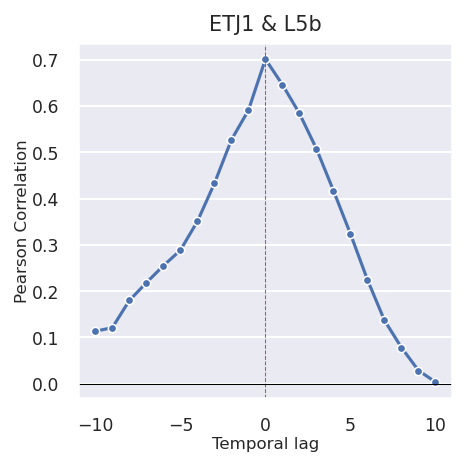

In [400]:
axes = plot_corrs_single(["ETJ1", "L5b"], corr, lags, [], specie, target, type_corr='pearson', annotate=0, subplots_per_line=1)
axes[0].set_ylabel(pearson_axis, size=8)
axes[0].set_xlabel(lag_axis, size=8)

plt.savefig(f'{image_dir}pearson_example.png')
plt.show()

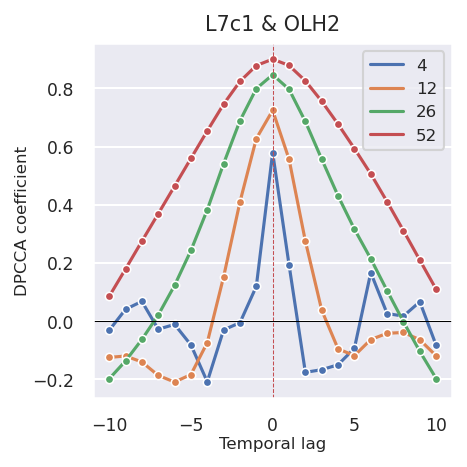

In [421]:
axes = plot_dpcca_single(["OLH2", "L7c1"], 0.1, lags,  [], specie, target, type_corr='dpcca', k_range=[4,12,26,52],
                 subplots_per_line=1)
axes[0].set_ylabel(dpcca_axis, size=8)
axes[0].set_xlabel(lag_axis, size=8)
axes[0].legend(prop={"size":8})

plt.savefig(f'{image_dir}dpcca_example.png')

plt.show()

# Exploratory Analysis

In [216]:
areas = ["L2", "RIAV1", "RIAV2", "LOB", "L5b", "ETJ1", "L7c1", "OLH2", "LAG"]
regions = {"North": ["L2", "RIAV1", "RIAV2"], "West": ["LOB", "L5b", "ETJ1"], "South": ["L7c1", "OLH2", "LAG"]}
species = "Mexilhão"

ts_week = []
ts_month = []
for area in areas:
    ts_week.append(get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W", plot=False))
    ts_month.append(get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M", plot=False))

## Seasonality

### Line plot - separated

Choose

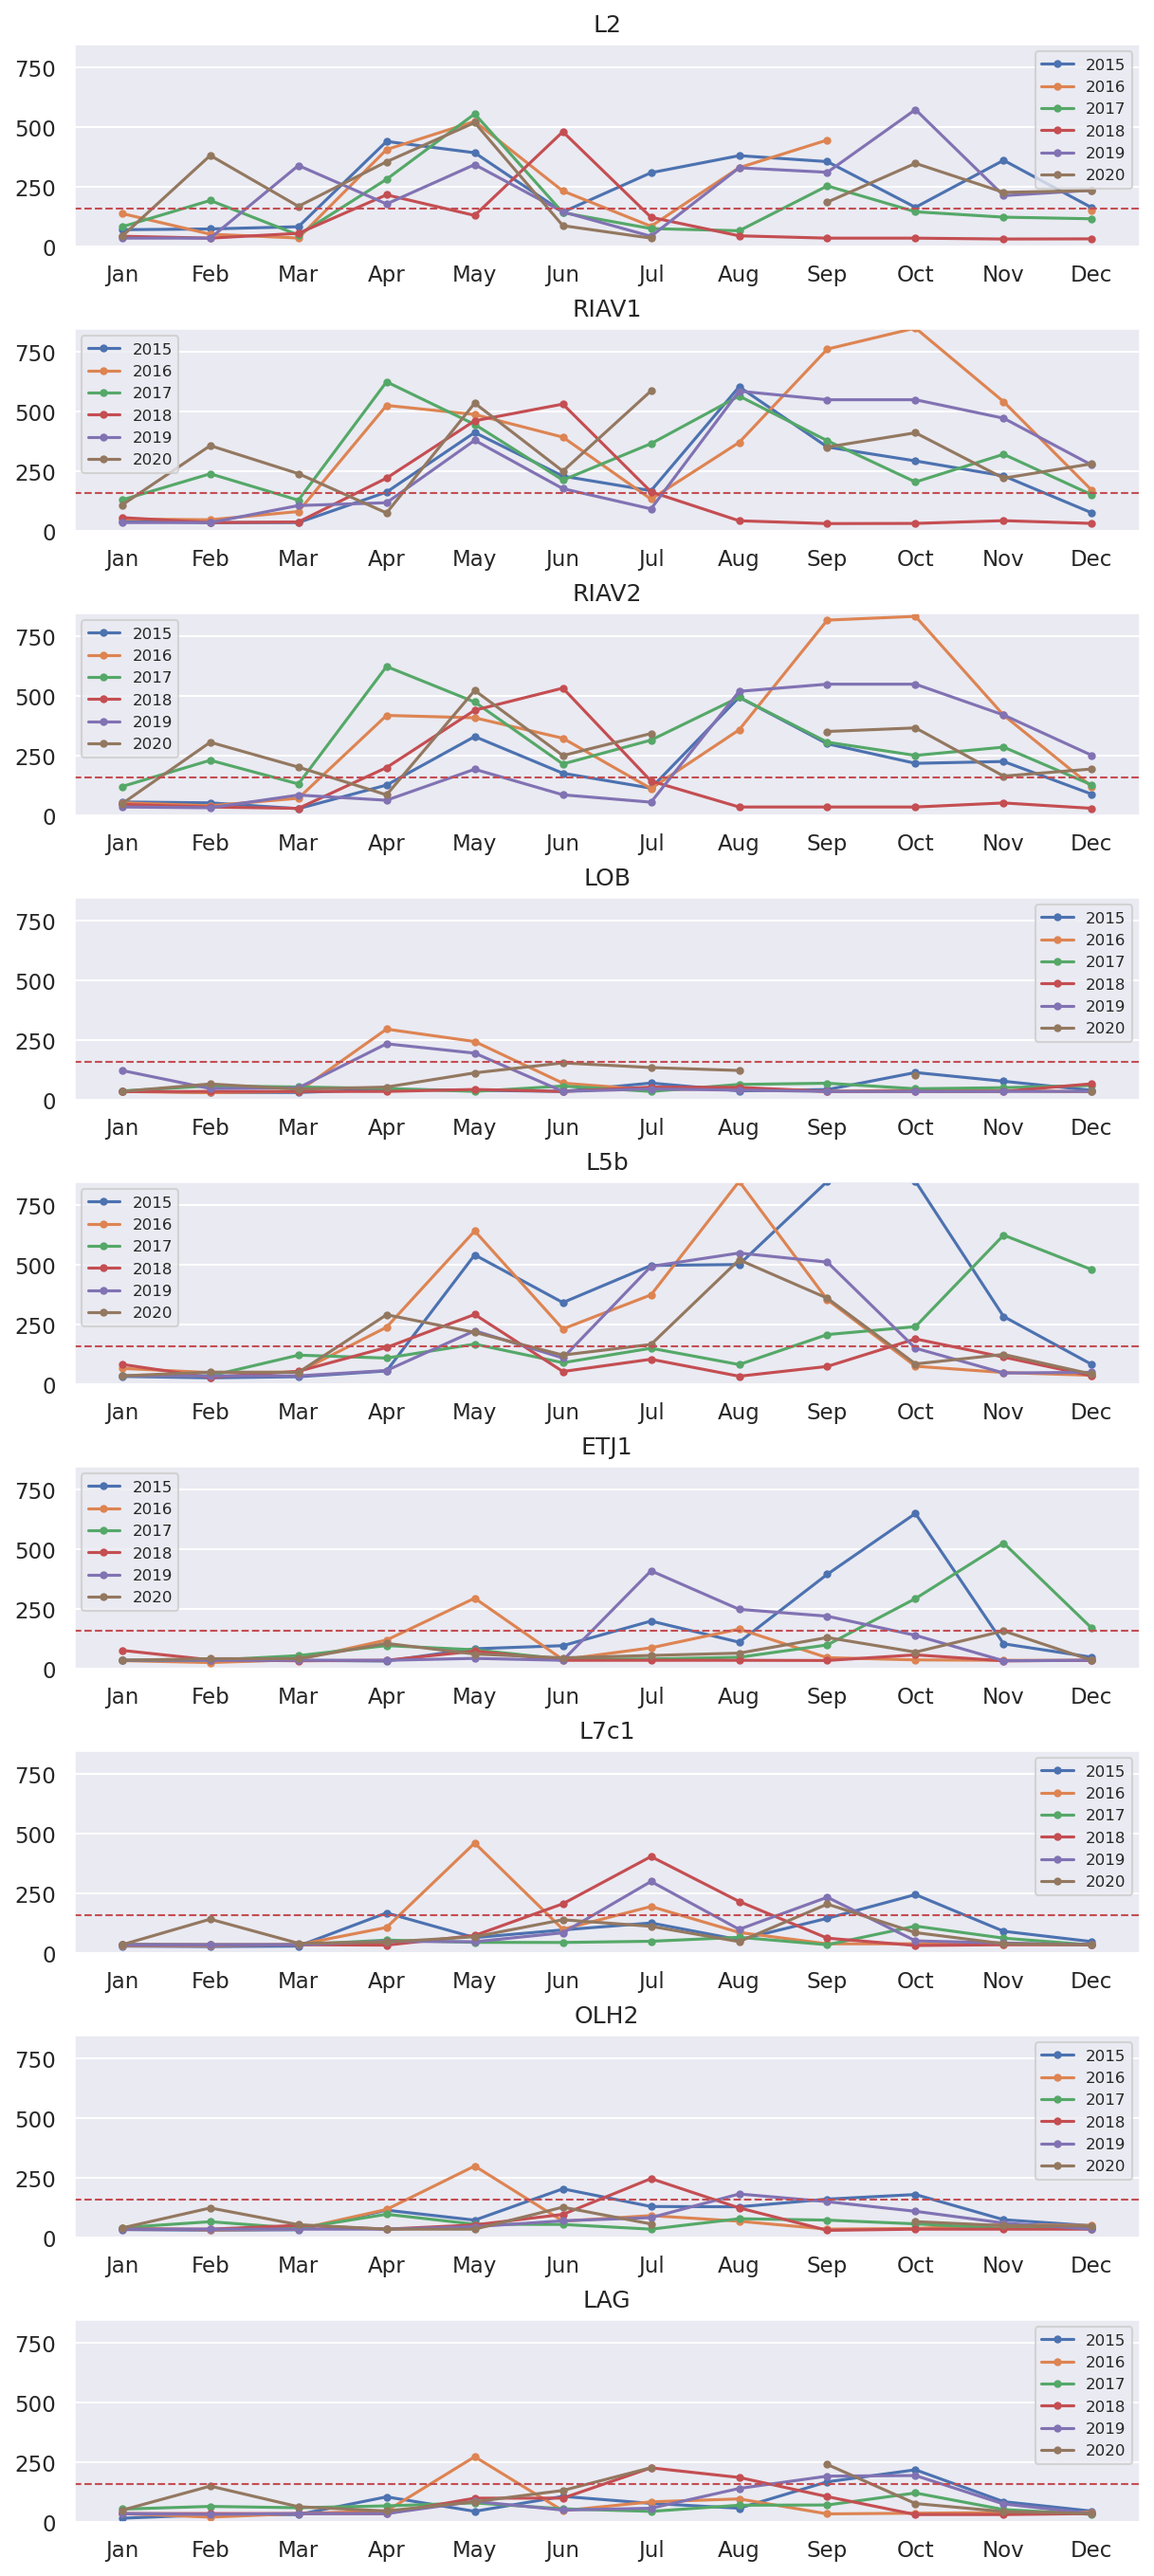

In [217]:
fig, axes = plt.subplots(len(ts_month),1, figsize=(8,18), constrained_layout=True)

for i in range(len(ts_month)):
    axes[i] = plot_season_per(ts_month[i], 'm', axes[i])
    axes[i].set_ylim(0,850)
    axes[i].set_title(areas[i])
    axes[i].legend(prop={'size': 8})
    
plt.show()

Generate

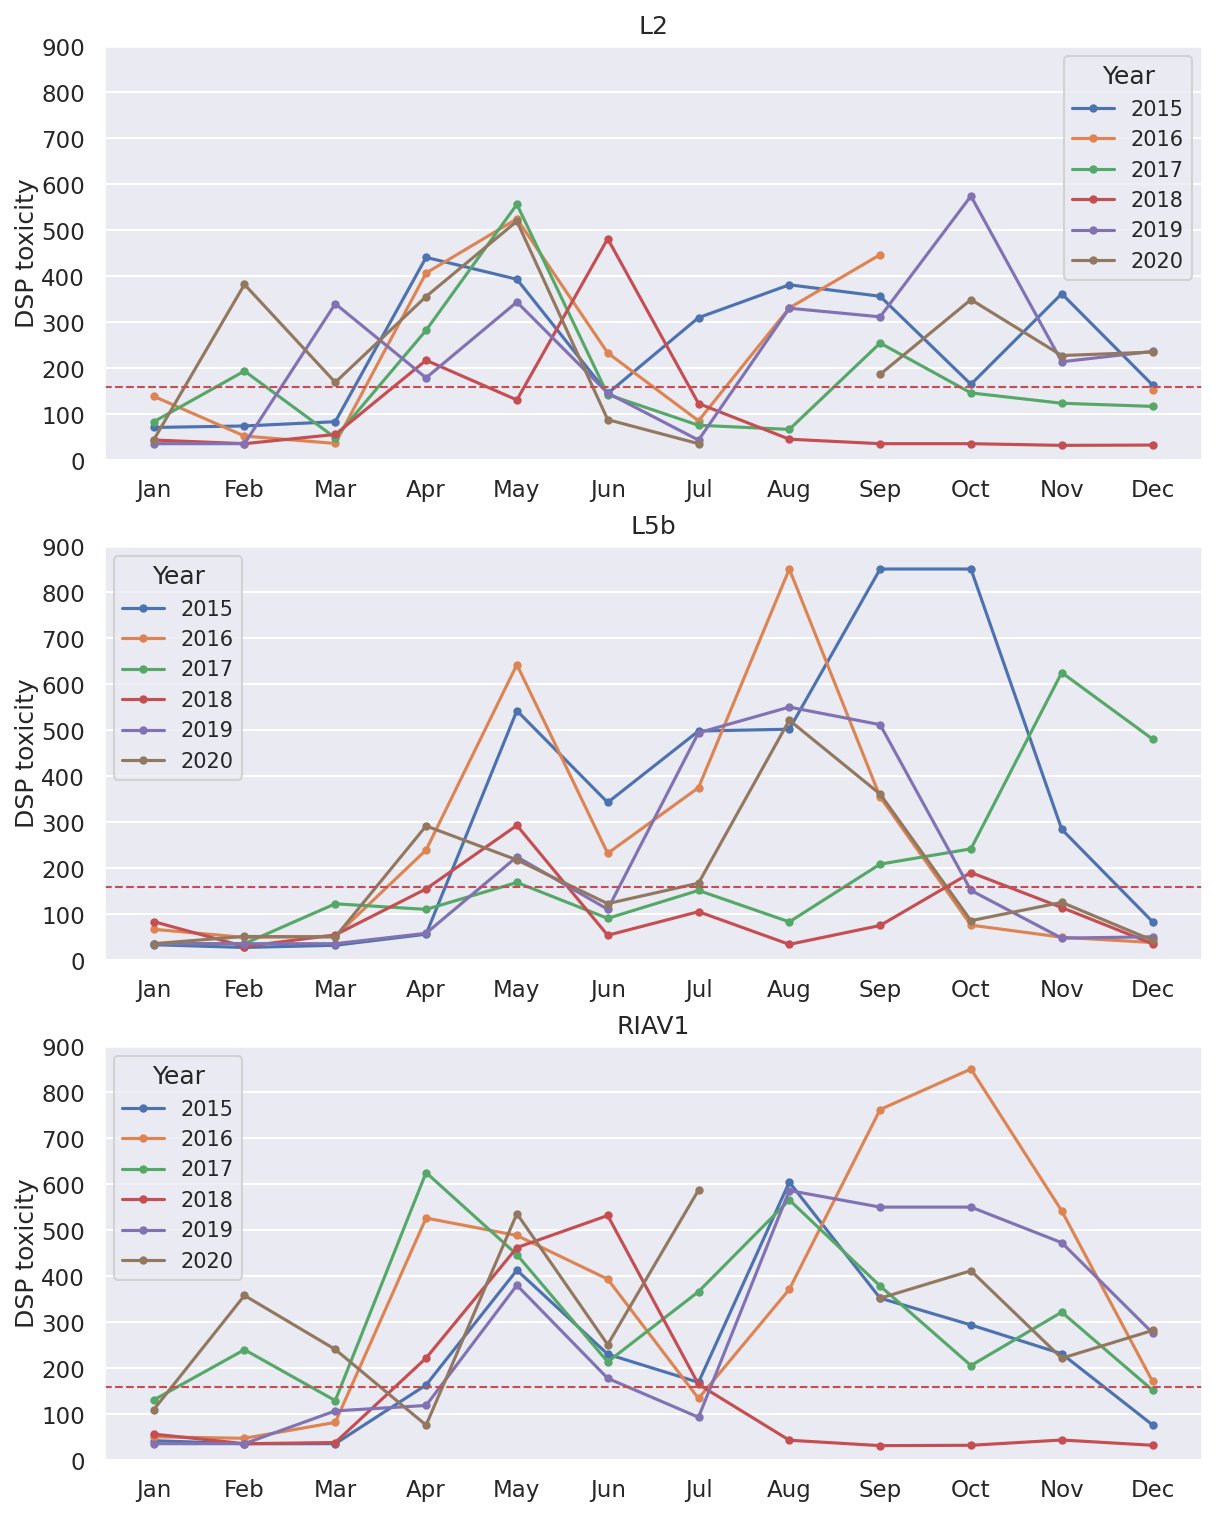

In [218]:
areas_generate = ["L2", "L5b", "RIAV1"]
fig, axes = plt.subplots(len(areas_generate),1, figsize=(8,10), constrained_layout=True)

for i,area in enumerate(areas_generate):
    ts = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M", plot=False)
    axes[i] = plot_season_per(ts, 'm', axes[i])
    axes[i].set_ylim(0,900)
    axes[i].set_title(area)
    axes[i].set_ylabel(dsp_axis)
    axes[i].legend(prop={'size': 10}, title="Year")
    
plt.savefig(f'{image_dir}seasonality_line_separated.png')
plt.show()

### Region

**All**

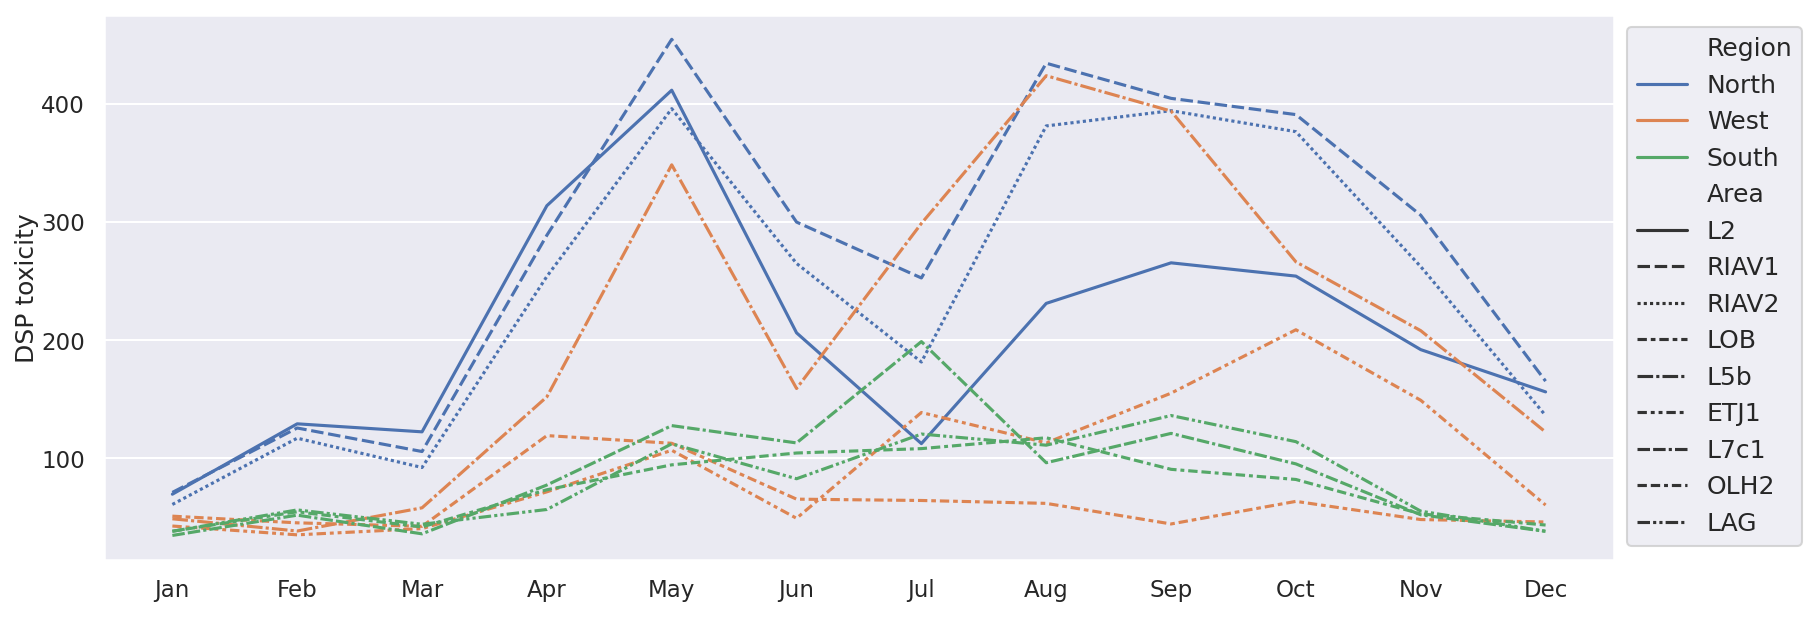

In [219]:
region_ts = pd.DataFrame(columns=ts_month[0].columns.tolist() + ["Area","Region"])
for ts, area in zip(ts_month, areas):
    t = ts.copy()
    t["Area"] = area
    for r in regions:
        if area in regions[r]:
            t["Region"] = r
    
    region_ts = region_ts.append(t)
region_ts['per'] = [d.strftime("%b") for d in region_ts.index]
region_ts = region_ts.reset_index(drop = True)


fig, ax = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
sns.lineplot(data=region_ts, x="per", y="dsp_toxins", hue="Region", style="Area",
             ax=ax, ci=None)
ax.legend(bbox_to_anchor=(1, 1),prop={'size': 12})
ax.set_ylabel(dsp_axis)
ax.set_xlabel("")

plt.savefig(f'{image_dir}seasonality_line_region_all.png')
plt.show()

**Separated**

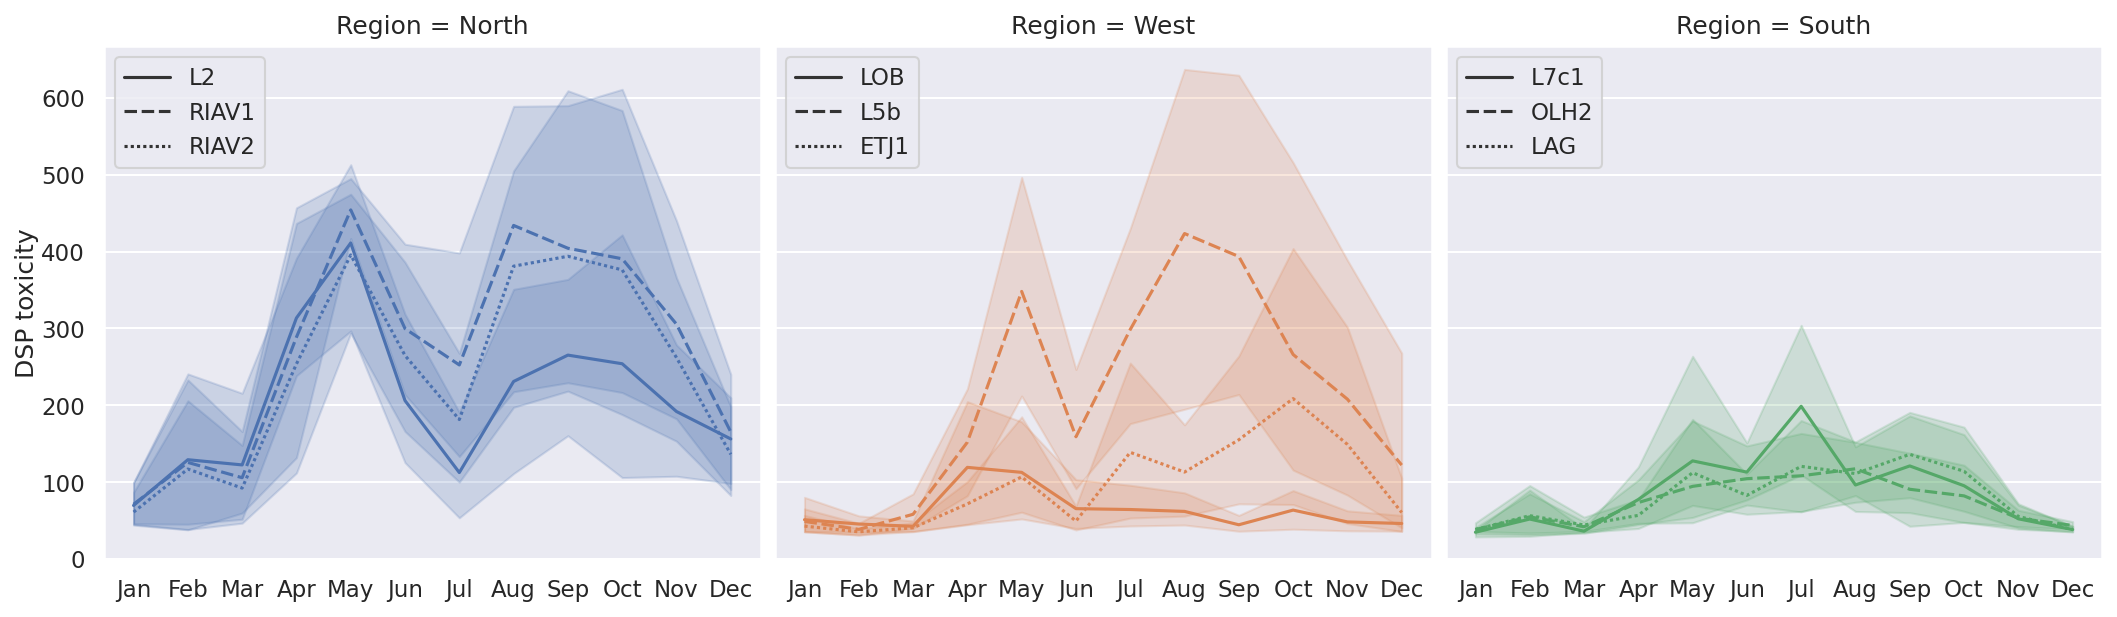

In [220]:
region_names = region_ts["Region"].unique()
fig, ax = plt.subplots(1,len(region_names), figsize=(14,4), constrained_layout=True, sharey=True)

for i, r in enumerate(region_names):
    temp_region_ts = region_ts[ region_ts["Region"]==r]
    sns.lineplot(data=temp_region_ts, x="per", y="dsp_toxins", style="Area", ax=ax[i], 
                 color=sns.color_palette()[i])
    ax[i].set_ylabel(dsp_axis)
    ax[i].set_xlabel("")
    ax[i].legend(title="", loc="upper left")
    ax[i].set_title(f"Region = {r}")
    
plt.savefig(f'{image_dir}seasonality_line_region_separated.png')
plt.show()

## Trend

**All**

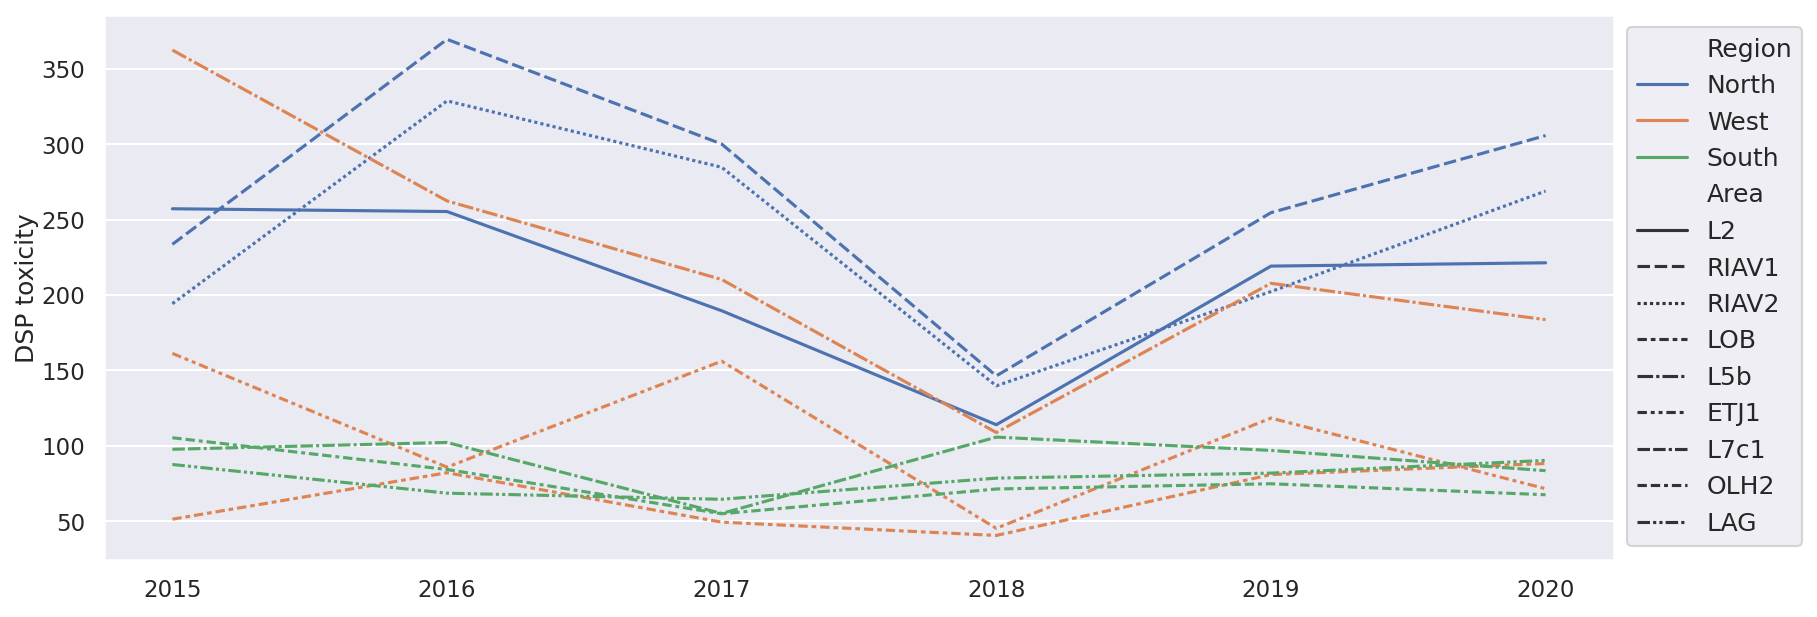

In [221]:
region_ts = pd.DataFrame(columns=ts_week[0].columns.tolist() + ["Area","Region"])

for ts, area in zip(ts_week, areas):
    t = ts.copy()
    t["Area"] = area
    for r in regions:
        if area in regions[r]:
            t["Region"] = r
    
    region_ts = region_ts.append(t)
region_ts['per'] = [int(d.strftime("%Y")) for d in region_ts.index]
region_ts = region_ts.reset_index(drop = True)

region_ts = region_ts[ region_ts["per"] < 2021 ]

fig, ax = plt.subplots(1,1, figsize=(12,4), constrained_layout=True)
sns.lineplot(data=region_ts, x="per", y="dsp_toxins", hue="Region", style="Area",
             ax=ax, ci=None)

ax.legend(bbox_to_anchor=(1, 1),prop={'size': 12})
ax.set_ylabel(dsp_axis)
ax.set_xlabel("")

plt.savefig(f'{image_dir}trend_line_region_all.png')
plt.show()

**Separated**

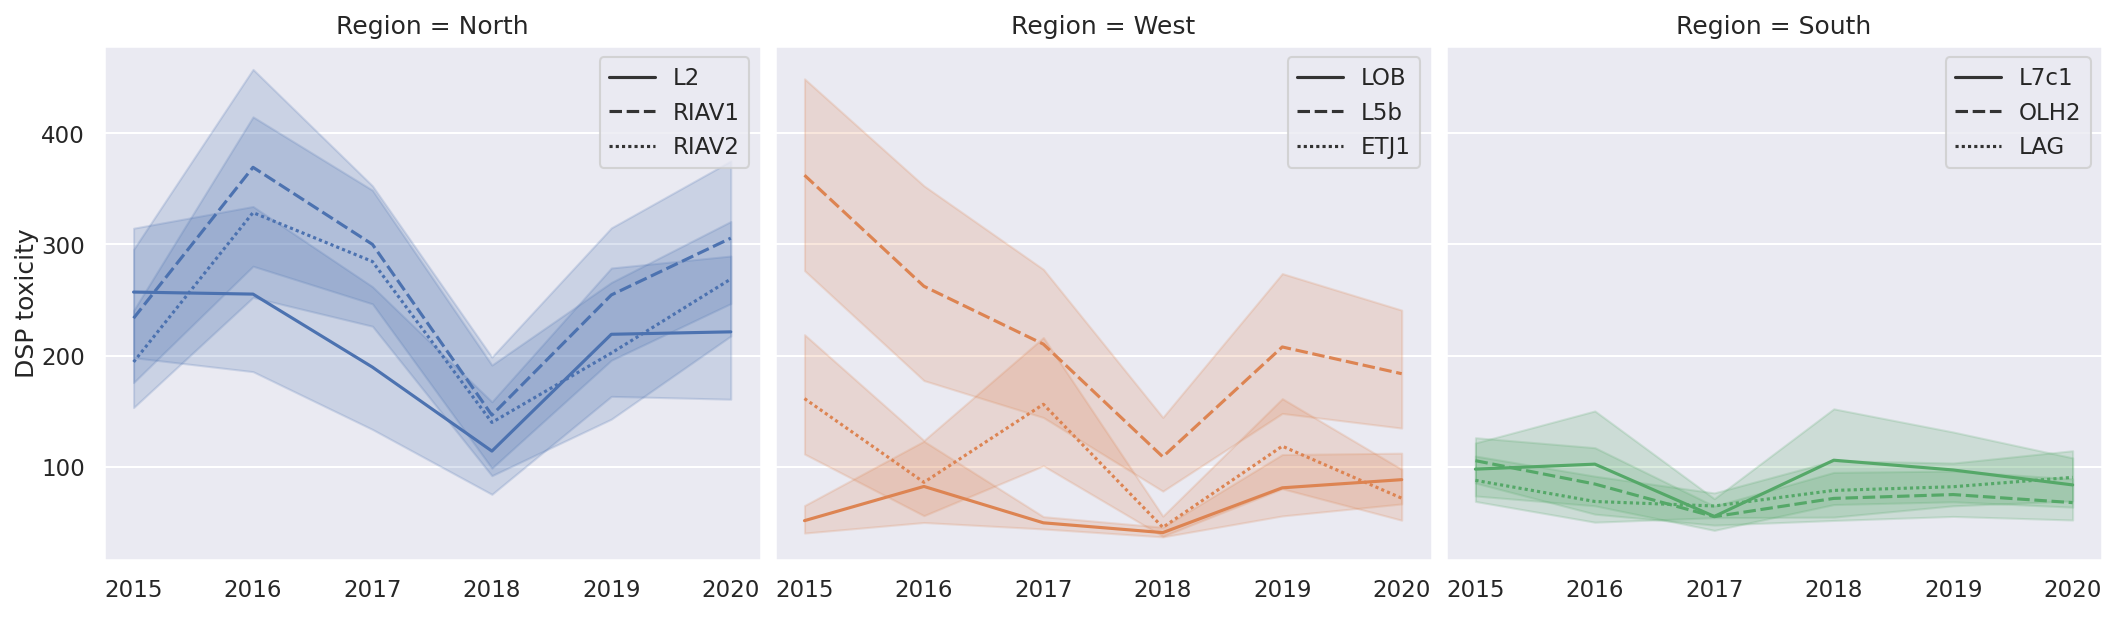

In [222]:
region_names = region_ts["Region"].unique()
fig, ax = plt.subplots(1,len(region_names), figsize=(14,4), constrained_layout=True, sharey=True)

for i, r in enumerate(region_names):
    temp_region_ts = region_ts[ region_ts["Region"]==r]
    sns.lineplot(data=temp_region_ts, x="per", y="dsp_toxins", style="Area", ax=ax[i], 
                 color=sns.color_palette()[i])
    ax[i].set_ylabel(dsp_axis)
    ax[i].set_xlabel("")
    ax[i].legend(title="", loc="upper right")
    ax[i].set_title(f"Region = {r}")
    
plt.savefig(f'{image_dir}trend_line_region_separated.png')
plt.show()

## Species

In [223]:
areas = ["OLH2", "L9"]
area = '_'.join(areas)

species = ["Mexilhão", "Conquilha"]

#merge de L9 com OLH2
temp = biotoxins_ts.copy()
#drop mexilhao de um lado e conquilha do outro:
for i in range(len(areas)):
    temp = temp[ ~((temp["Production_Area"]==areas[i]) & (temp["Species"]==list(reversed(species))[i])) ]
    
temp.loc[ temp["Production_Area"].isin(areas), "Production_Area"] = area
#temp[ (temp["Production_Area"]==area)]["Species"].value_counts()

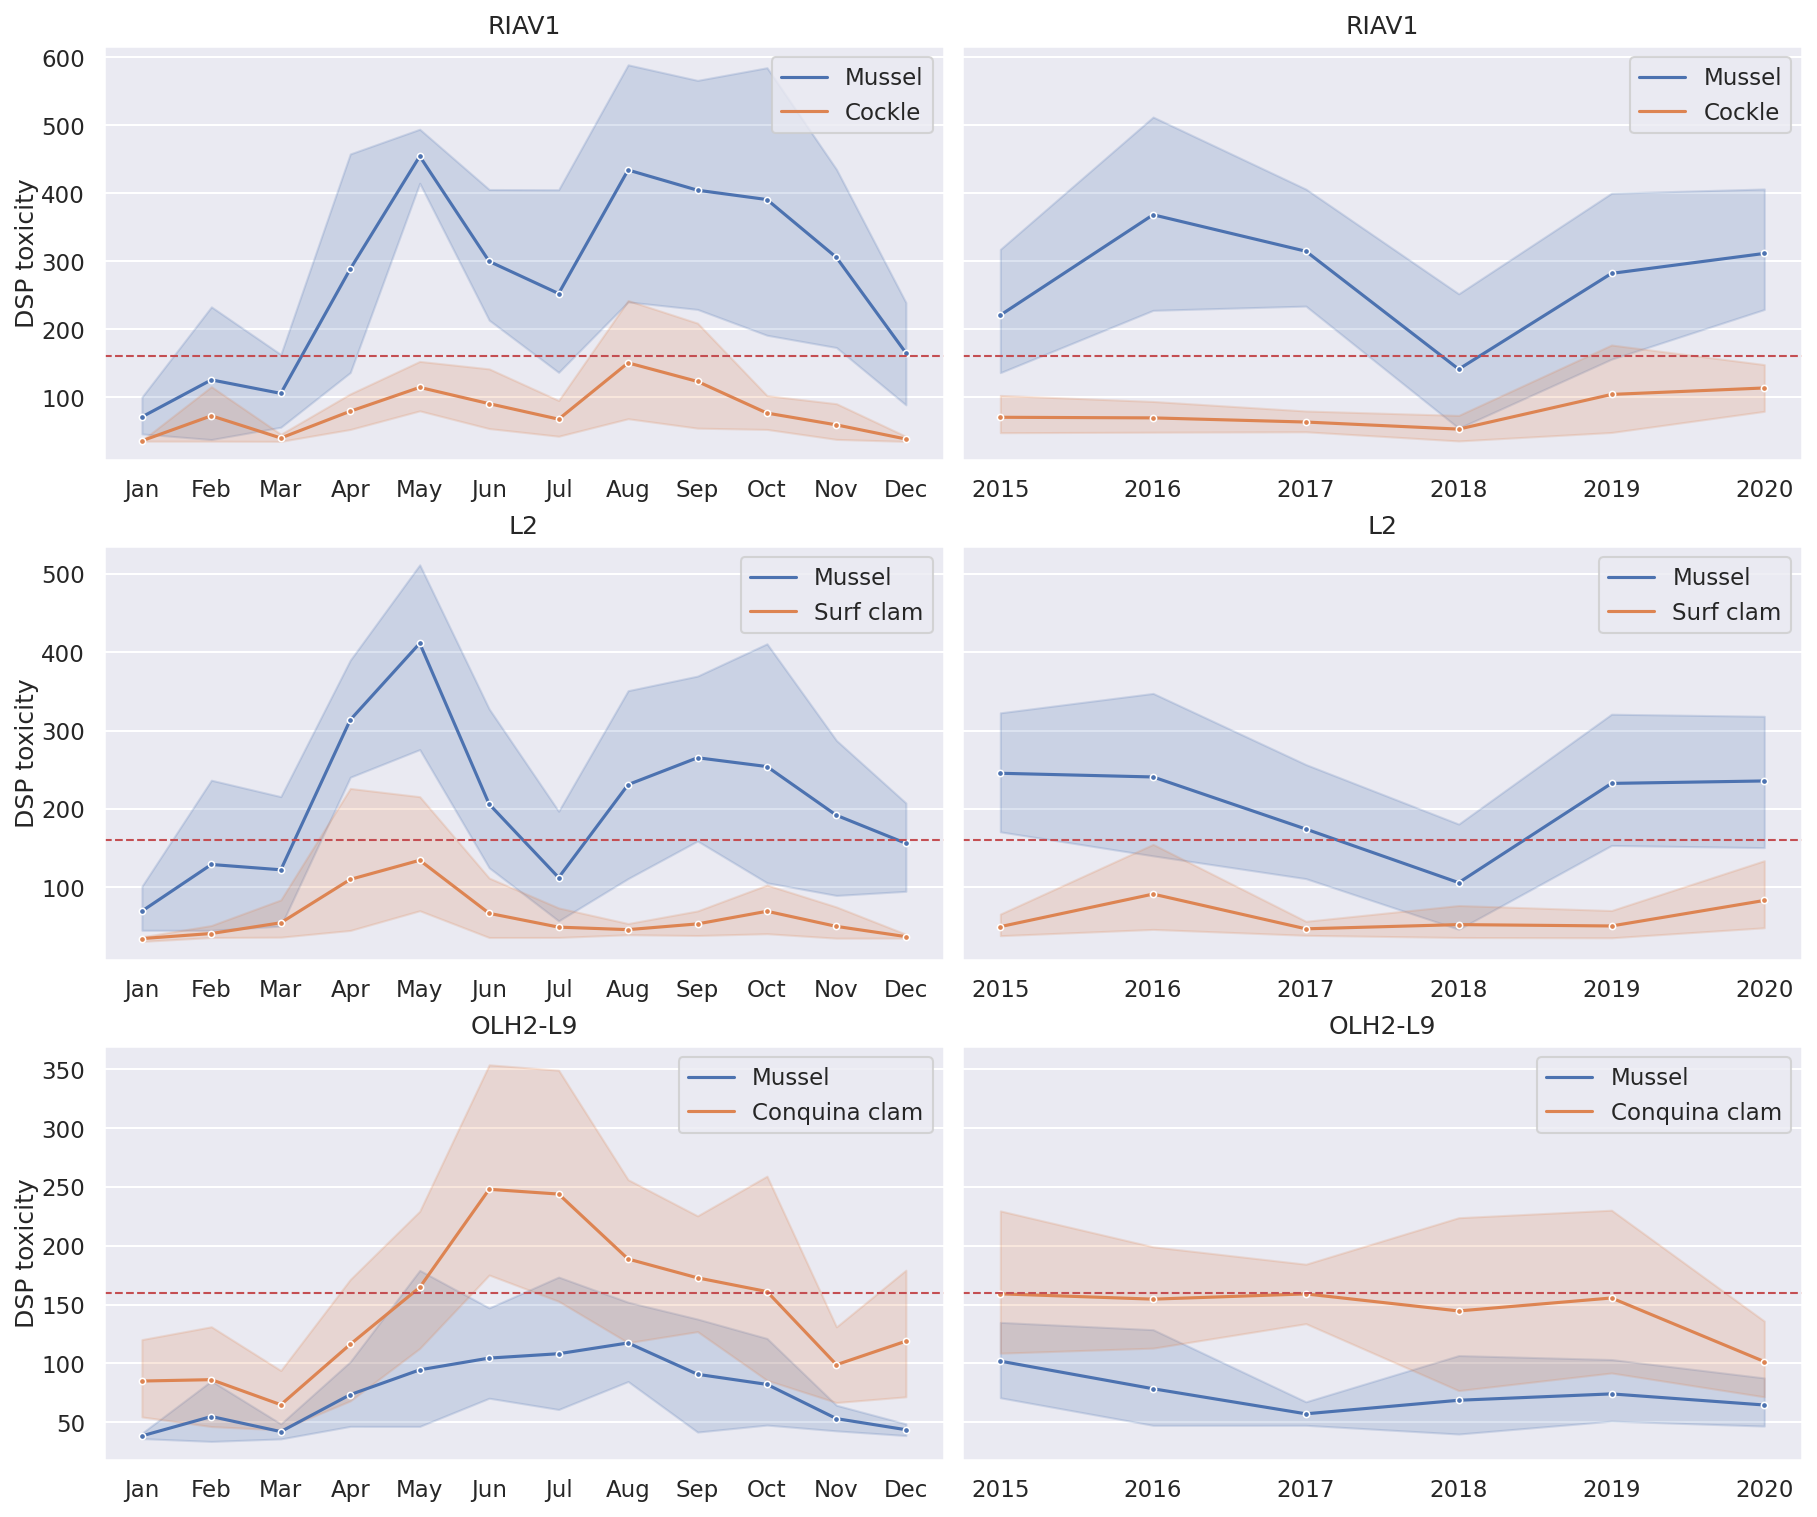

In [224]:
biotoxins_ts["Species"] = biotoxins_ts["Species"].replace({"Mexilhão": "Mussel", "Berbigão":"Cockle", 
                                                           "Amêijoa-branca": "Surf clam", "Conquilha":"Conquina clam"})

by="M"
fig, ax = plt.subplots(3,2, figsize=(12,10), constrained_layout=True, sharey="row")

ax[0][0] = compare_species_seasonality(biotoxins_ts, "RIAV1", ["Mussel", "Cockle"], "dsp_toxins", by, ax[0][0], 160,"lineplot")
ax[0][0].set_title("RIAV1")
ax[0][1] = compare_species_trend(biotoxins_ts, "RIAV1", ["Mussel", "Cockle"], "dsp_toxins", ax[0][1], 160,"lineplot")
ax[0][1].set_title("RIAV1")

ax[1][0] = compare_species_seasonality(biotoxins_ts, "L2", ["Mussel", "Surf clam"], "dsp_toxins", by, ax[1][0], 160,"lineplot")
ax[1][0].set_title("L2")
ax[1][1] = compare_species_trend(biotoxins_ts, "L2", ["Mussel", "Surf clam"], "dsp_toxins", ax[1][1], 160,"lineplot")
ax[1][1].set_title("L2")

ax[2][0] = compare_species_seasonality(temp, area, ["Mussel", "Conquina clam"], "dsp_toxins", by, ax[2][0], 160,"lineplot")
ax[2][0].set_title("OLH2-L9")
ax[2][1] = compare_species_trend(temp, area, ["Mussel", "Conquina clam"], "dsp_toxins", ax[2][1], 160,"lineplot")
ax[2][1].set_title("OLH2-L9")

ax[0][0].set_ylabel(dsp_axis)
ax[1][0].set_ylabel(dsp_axis)
ax[2][0].set_ylabel(dsp_axis)

ax[0][0].set_xlabel("")
ax[0][1].set_xlabel("")
ax[1][0].set_xlabel("")
ax[1][1].set_xlabel("")
ax[2][0].set_xlabel("")
ax[2][1].set_xlabel("")

ax[0][0].legend(title="")
ax[0][1].legend(title="")
ax[1][0].legend(title="")
ax[1][1].legend(title="")
ax[2][0].legend(title="")
ax[2][1].legend(title="")

plt.savefig(f'{image_dir}species_components.png')
plt.show()

biotoxins_ts["Species"] = biotoxins_ts["Species"].replace({"Mussel":"Mexilhão", "Cockle":"Berbigão", 
                                                            "Surf clam": "Amêijoa-branca","Conquina clam":"Conquilha"})


# Correlations

## DSP

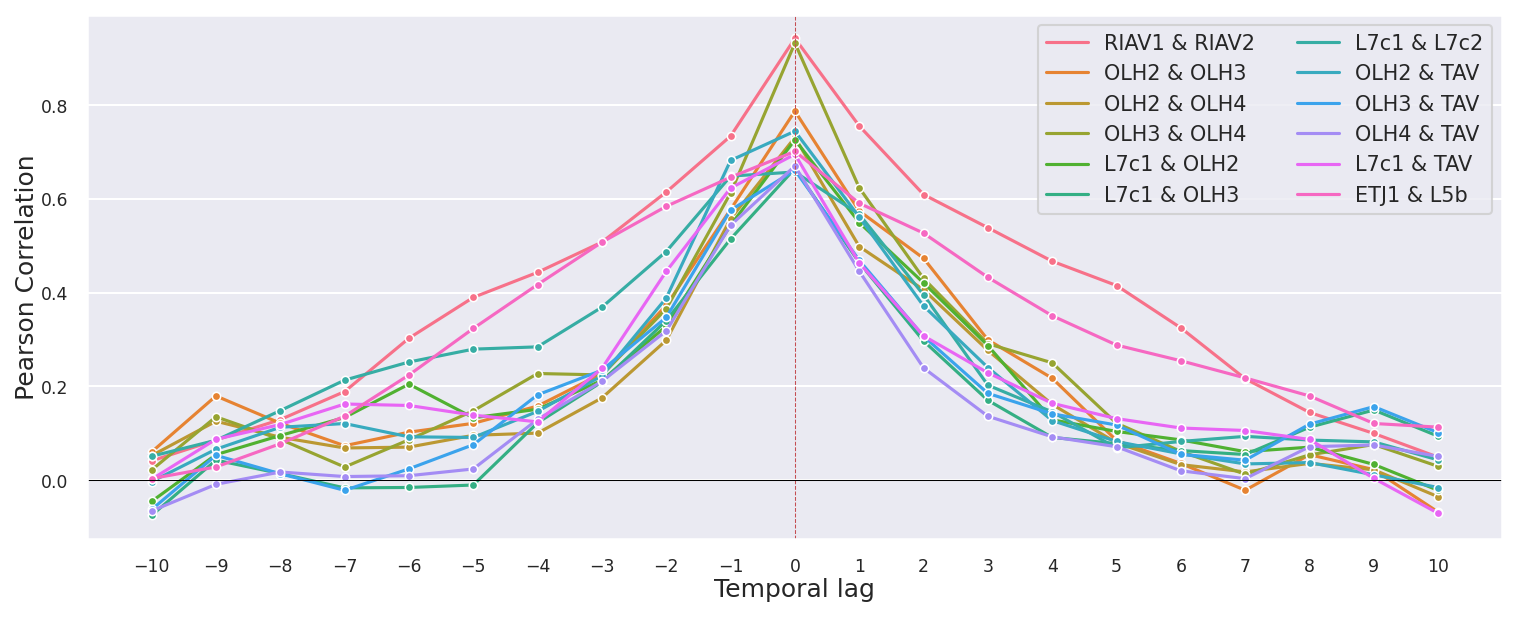

In [269]:
suf = "areacorr"
lags = np.arange(-10, 11, 1)
specie = "Mexilhão"
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()

target = "dsp_toxins"

fig, axes = plt.subplots(1, 1,  figsize=(10, 4), constrained_layout=True, sharey=True)

axes = plot_corrs_together(all_areas, 0.65, lags, [], specie, target, type_corr='pearson', axes=axes)

axes.legend(title="", ncol=2, prop={'size': 10})
axes.set_ylabel(pearson_axis)
axes.set_xlabel(lag_axis)
axes.set_xticks(lags)

plt.savefig(f'{image_dir}pearson_areas_dsp.png')
plt.show()

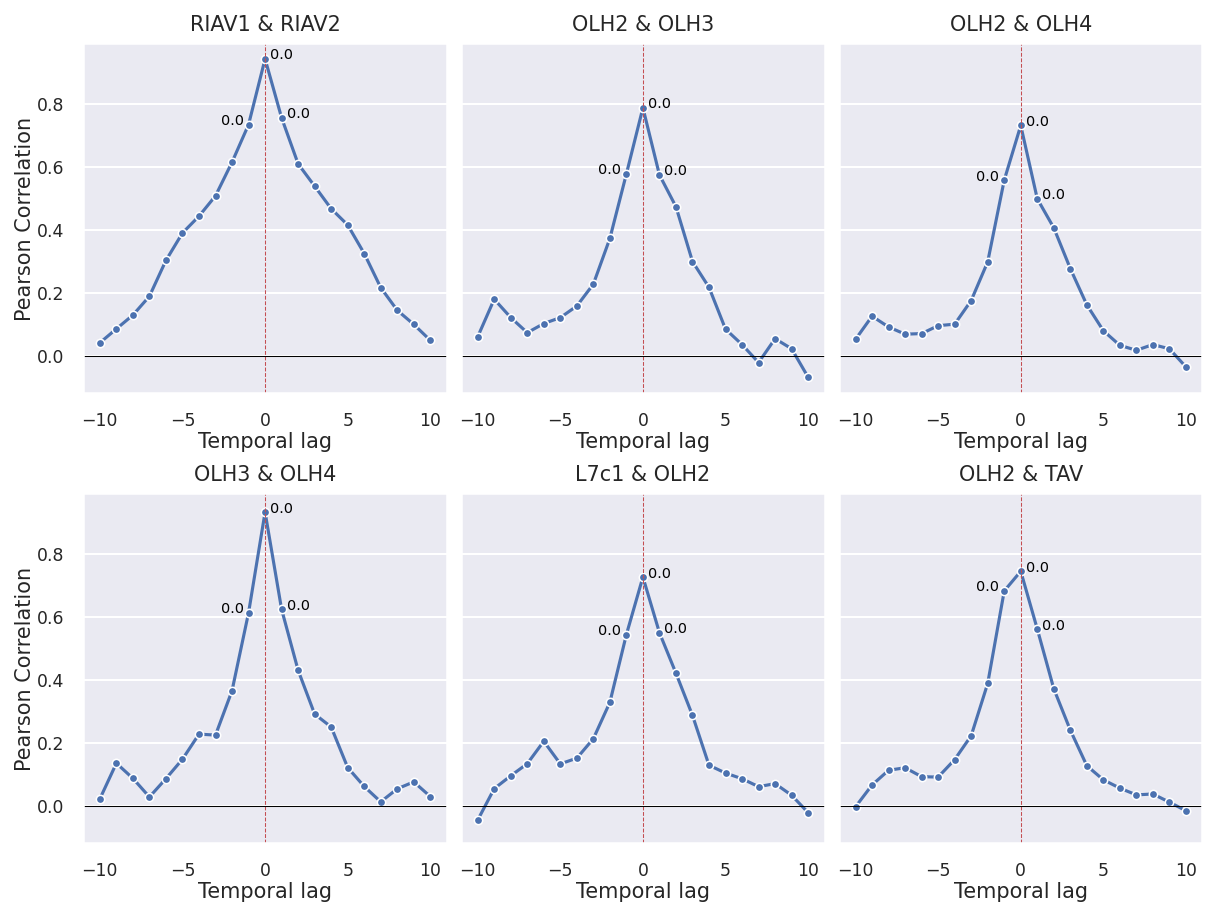

In [270]:
axes = plot_corrs_single(all_areas, 0.71, lags, [], specie, target, type_corr='pearson', annotate=3, 
                  subplots_per_line=3)

ysize=10
xsize=10
axes[0].set_ylabel(pearson_axis, size=ysize)
axes[3].set_ylabel(pearson_axis, size=ysize)

axes[0].set_xlabel(lag_axis, size=xsize)
axes[1].set_xlabel(lag_axis, size=xsize)
axes[2].set_xlabel(lag_axis, size=xsize)
axes[3].set_xlabel(lag_axis, size=xsize)
axes[4].set_xlabel(lag_axis, size=xsize)
axes[5].set_xlabel(lag_axis, size=xsize)

plt.savefig(f'{image_dir}pearson_areas_dsp_separated.png')

plt.show()

## ASP

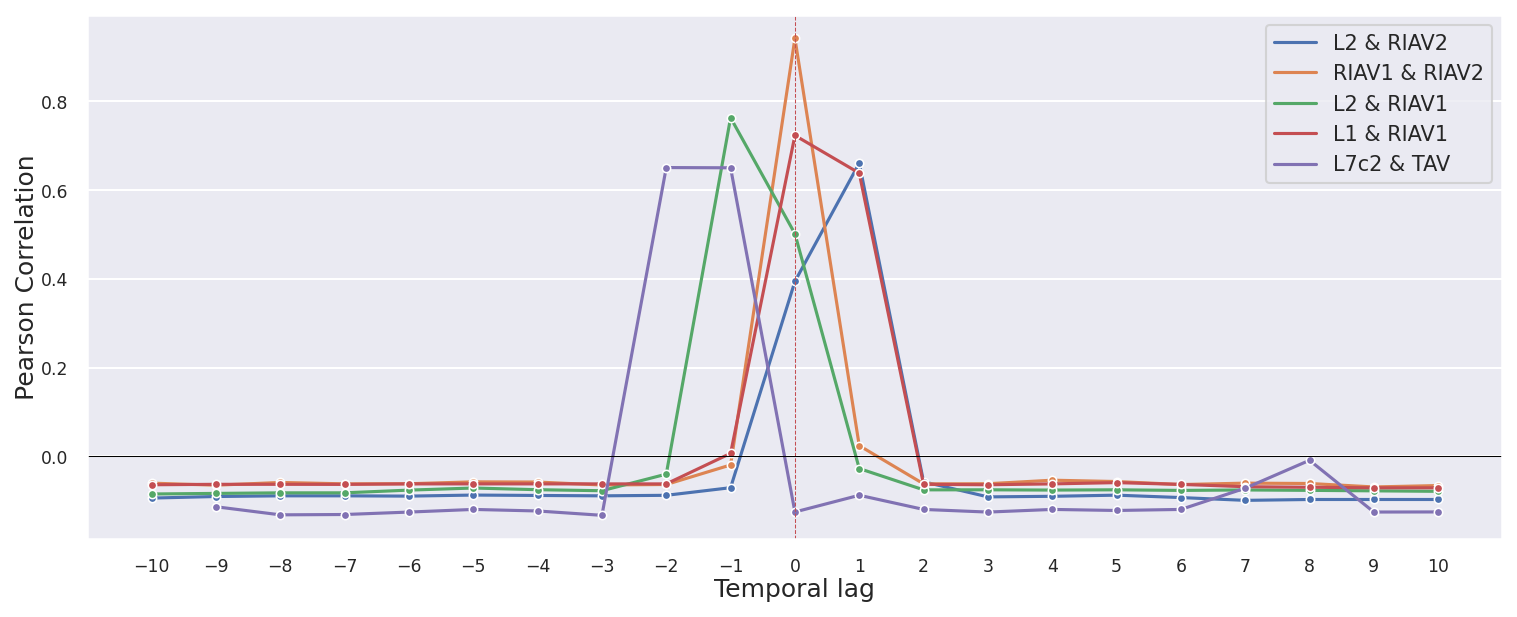

In [271]:
suf = "areacorr"
lags = np.arange(-10, 11, 1)
specie = "Mexilhão"
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()

target = "asp_toxins"

fig, axes = plt.subplots(1, 1,  figsize=(10, 4), constrained_layout=True, sharey=True)

plot_corrs_together(all_areas, 0.65, lags, [], specie, target, type_corr='pearson', remove_default=True, axes=axes)

axes.legend(title="", ncol=1, prop={'size': 10})
axes.set_ylabel(pearson_axis)
axes.set_xlabel(lag_axis)
axes.set_xticks(lags)

plt.savefig(f'{image_dir}pearson_areas_asp.png')
plt.show()

## DPCCA - DSP

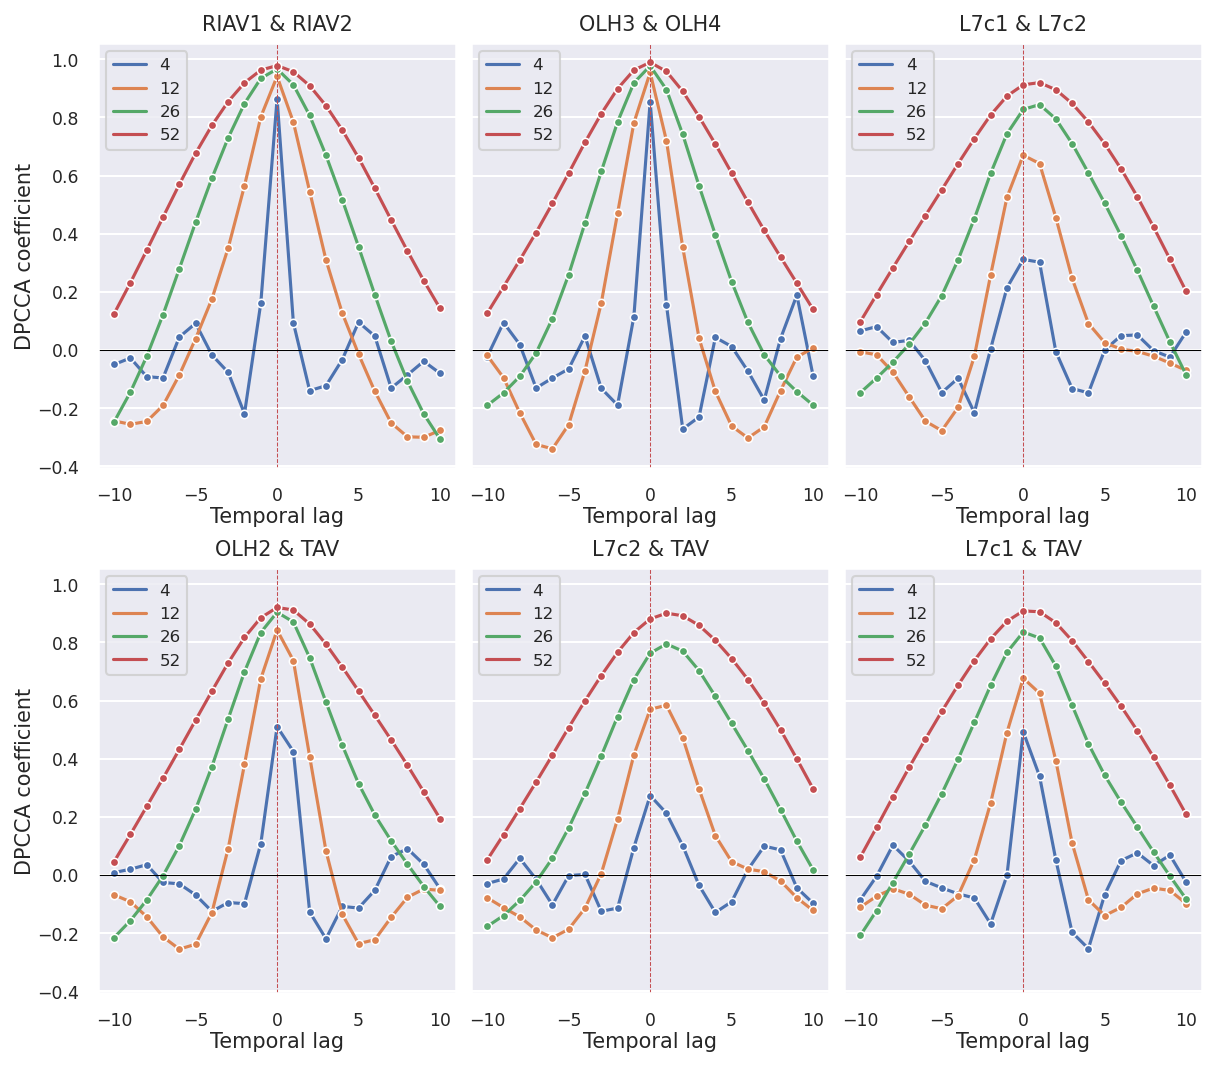

In [300]:
suf = "areacorr"
lags = np.arange(-10, 11, 1)
specie = "Mexilhão"
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()

target = "dsp_toxins"

axes = plot_dpcca_single(all_areas, 0.9, lags,  [], specie, target, type_corr='dpcca', k_range=[4,12,26,52],
                 subplots_per_line=3)

for ax in axes:
    ax.legend(prop={'size': 8}, loc = "upper left")
    ax.set_xlabel(lag_axis, size=10)
    
axes[0].set_ylabel(dpcca_axis, size=10)
axes[3].set_ylabel(dpcca_axis, size=10)

#axes.set_xticks(lags)

plt.savefig(f'{image_dir}dpcca_areas_dsp.png')

plt.show()

## Species

### Pearson

RIAV2
Berbigão Mexilhão
L2
Mexilhão Amêijoa-branca
OLH2-L9
Conquilha Mexilhão


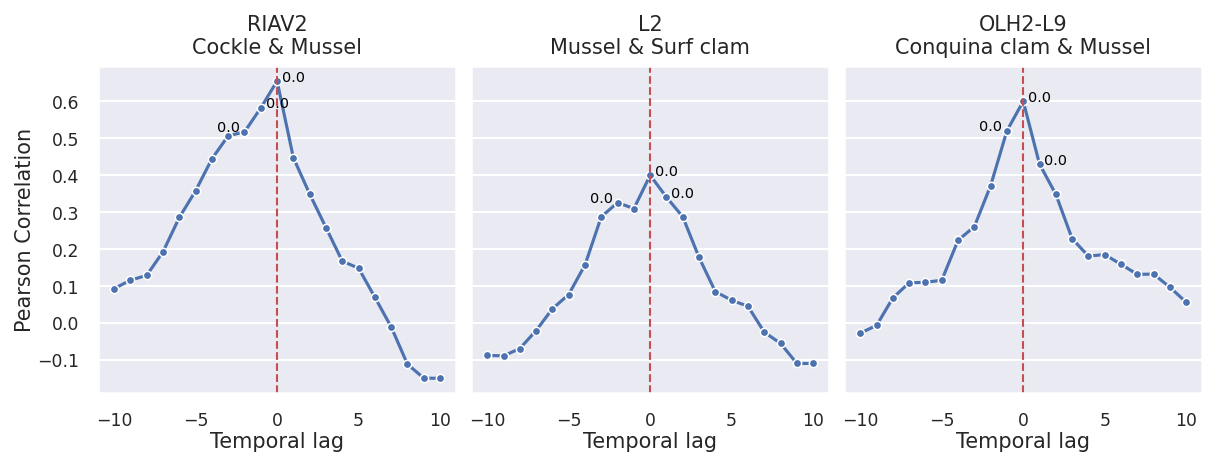

In [374]:
species_to_impute = {'RIAV2': ['Mexilhão', 'Berbigão'],
 'L2': ['Amêijoa-branca', 'Mexilhão'],
 #'LOB': ['Berbigão', 'Mexilhão'],
 'OLH2-L9': ['Mexilhão', 'Conquilha']}

lags = np.arange(-10, 11, 1)
target="dsp_toxins"

axes = plot_corrs_single_species(species_to_impute, lags, target, subplots_per_line=3, annotate=3)
axes[0].set_ylabel(pearson_axis, size=10)

for ax in axes:
    ax.set_xlabel(lag_axis, size=10)
    
plt.savefig(f'{image_dir}pearson_species_dsp.png')

plt.show()

### DPCCA

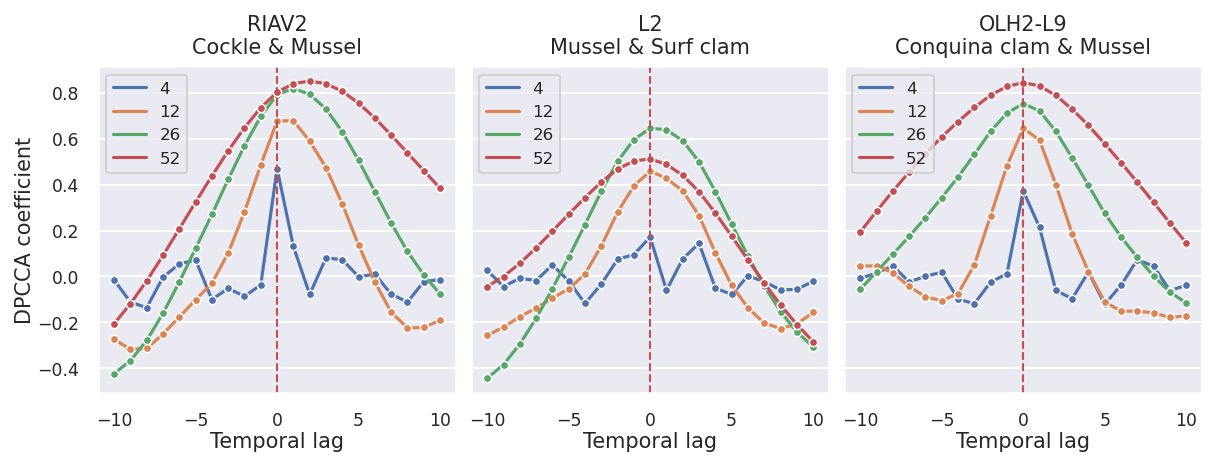

In [376]:
species_to_impute = {'RIAV2': ['Mexilhão', 'Berbigão'],
 'L2': ['Amêijoa-branca', 'Mexilhão'],
 #'LOB': ['Berbigão', 'Mexilhão'],
 'OLH2-L9': ['Mexilhão', 'Conquilha']}

all_areas = biotoxins_ts["Production_Area"].unique()
min_per_specie = 200

suf = "speciecorr"
lags = np.arange(-10, 11, 1)
target="dsp_toxins"

axes = plot_dpcca_single_species(species_to_impute, lags, target, k_range=[4, 12, 26, 52], subplots_per_line=3)
axes[0].set_ylabel(dpcca_axis, size=10)

for ax in axes:
    ax.legend(prop={'size': 8}, loc = "upper left")
    ax.set_xlabel(lag_axis, size=10)
    
plt.savefig(f'{image_dir}dpcca_species_dsp.png')

plt.show()

## Phytoplankton

In [319]:
specie = "Mexilhão"
lags = np.arange(-20, 21, 1)
all_areas = biotoxins_ts[biotoxins_ts["Species"]==specie]["Production_Area"].unique()

### DSP

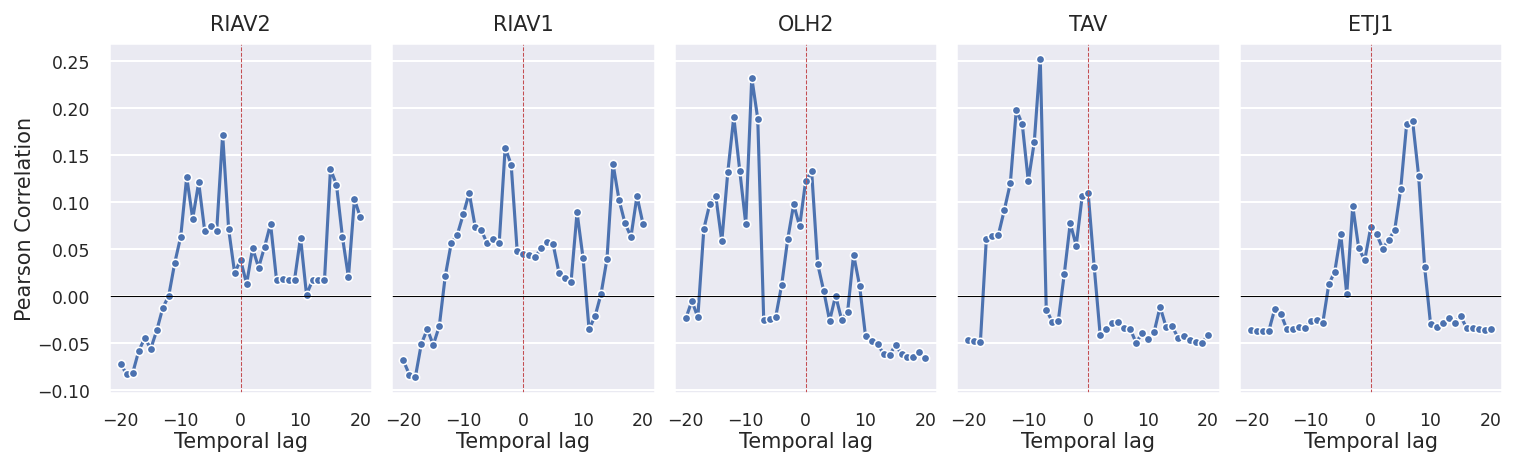

In [327]:
corr = 0.15
target = "dsp_toxins"
axes = plot_corrs_single_phyto(all_areas, corr, lags, specie, target, type_corr='pearson', subplots_per_line=5)

axes[0].set_ylabel(pearson_axis, size=10)

for ax in axes:
    ax.set_xlabel(lag_axis, size=10)
    
plt.savefig(f'{image_dir}pearson_phyto_dsp.png')

plt.show()

### ASP

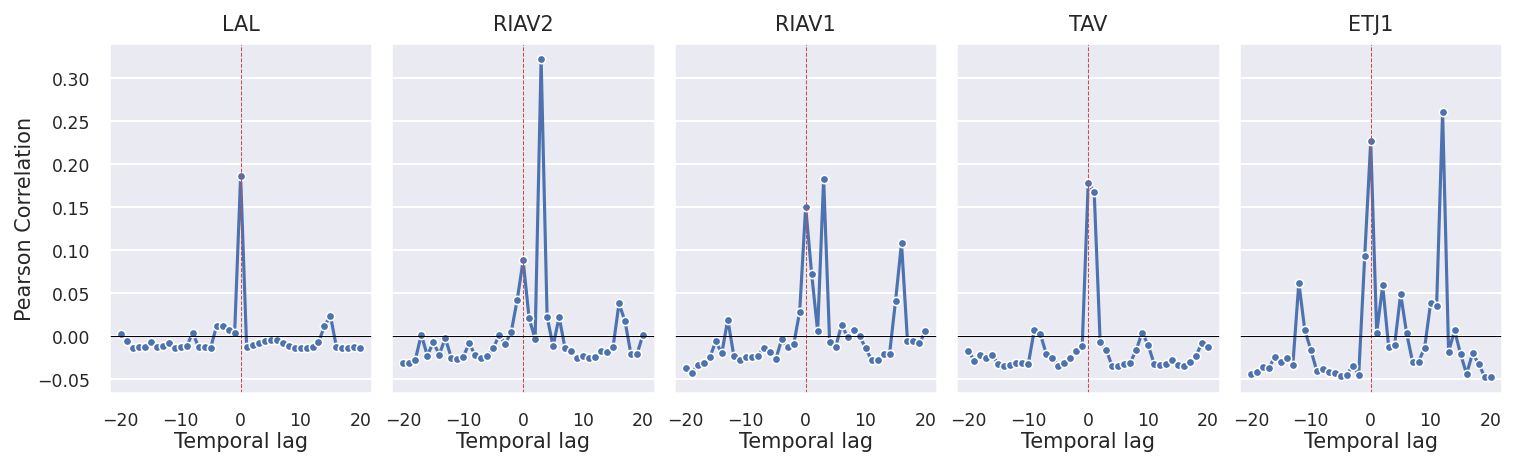

In [328]:
corr = 0.15
target = "asp_toxins"
axes = plot_corrs_single_phyto(all_areas, corr, lags, specie, target, type_corr='pearson', subplots_per_line=5)

axes[0].set_ylabel(pearson_axis, size=10)

for ax in axes:
    ax.set_xlabel(lag_axis, size=10)
    
plt.savefig(f'{image_dir}pearson_phyto_asp.png')

plt.show()

## Meteorological

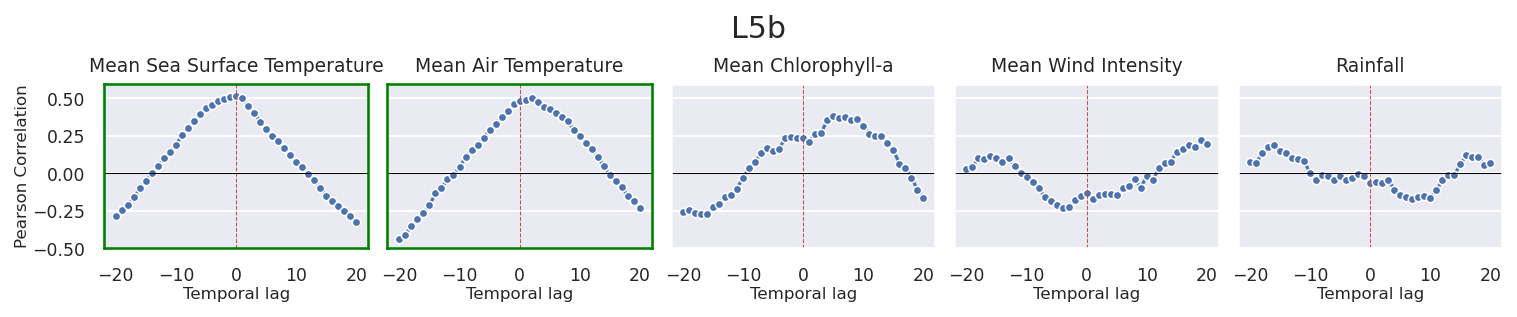

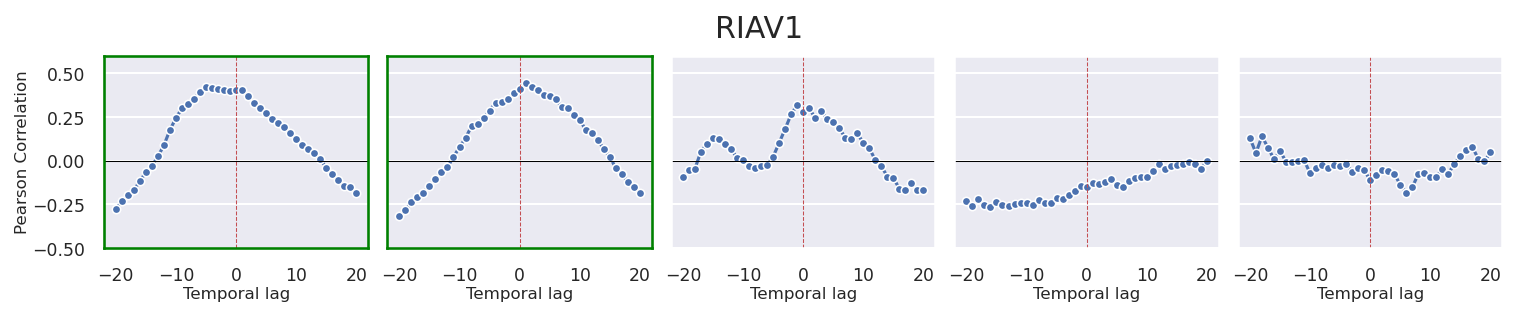

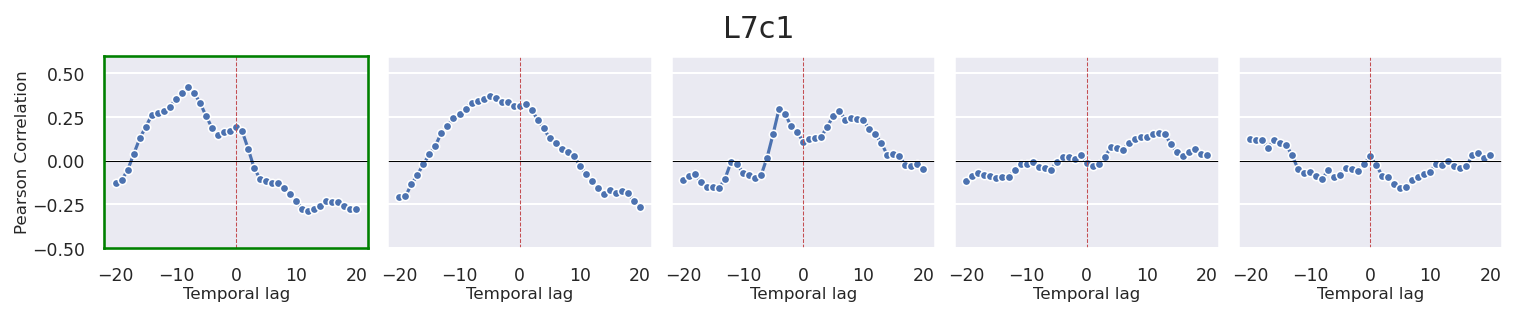

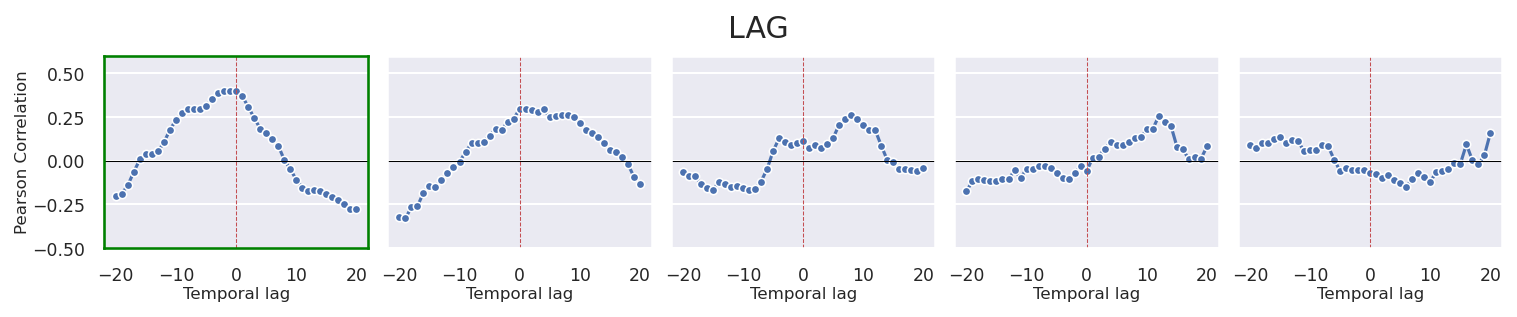

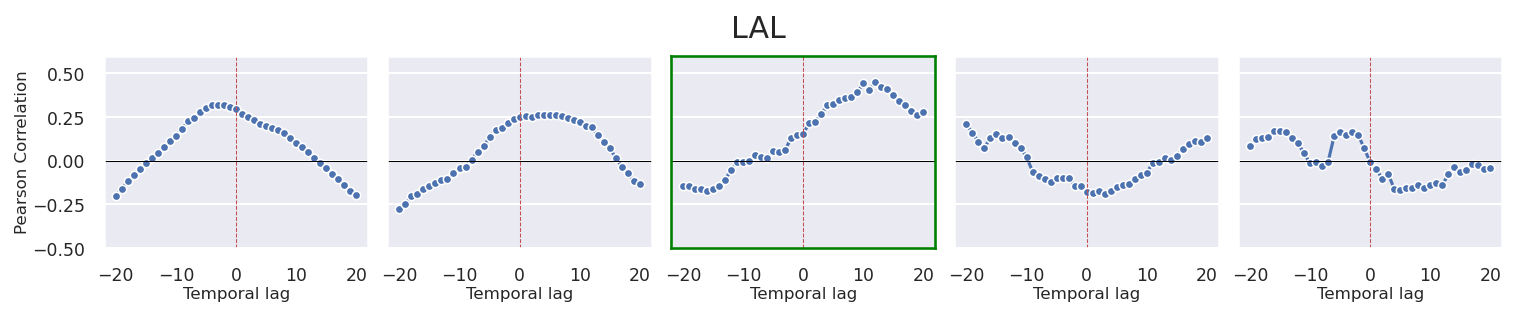

In [372]:
min_corr = 0.4
lags = np.arange(-20, 21, 1)
for j,area in enumerate(dataframes):
    ts = dataframes[area]
    cols = ["mean_sst", "mean_temp", "mean_chl","mean_wind_intensity","rainfall"]
    cols_names = ["Mean Sea Surface Temperature", "Mean Air Temperature", "Mean Chlorophyll-a", "Mean Wind Intensity", "Rainfall"]
    axes = plot_corrs_ipma_target(ts.copy(), cols, min_corr, lags, area=area, type_corr="Pearson", target="dsp_toxins")
    if len(axes)>0:
        axes[0].set_ylabel(pearson_axis, size=8)
        axes[0].set_yticks([0.5, 0.25, 0, -0.25, -0.5])
        for i,ax in enumerate(axes):
            ax.set_ylim(-0.5, 0.6)
            ax.set_xlabel(lag_axis, size=8)
            if j==0: 
                ax.set_title(cols_names[i], size=9)
            else:
                ax.set_title("")
